# <b>Mount drive and import</b>

(estamos usando data de una simulacion de Heston que hay que doble-chequear)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

SEED=1234

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from scipy import ndimage
from scipy.optimize import minimize
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler as ms
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
import torch
import keras

try:
  os.mkdir('drive/MyDrive/asamaci-2021')
except: 
  pass
finally:  
  try: 
    os.chdir('drive/MyDrive/asamaci-2021')
  except: 
    print('wrong directory error')

# Download and  unzip: only if it is the first time
!wget -nc "docs.google.com/uc?export=download&id=1V_Q514SvOM62PVUBRmax9pfFFcBBdYWK"
!unzip -n 'uc?export=download&id=1V_Q514SvOM62PVUBRmax9pfFFcBBdYWK'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ‘uc?export=download&id=1V_Q514SvOM62PVUBRmax9pfFFcBBdYWK’ already there; not retrieving.

Archive:  uc?export=download&id=1V_Q514SvOM62PVUBRmax9pfFFcBBdYWK
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of uc?export=download&id=1V_Q514SvOM62PVUBRmax9pfFFcBBdYWK or
        uc?export=download&id=1V_Q514SvOM62PVUBRmax9pfFFcBBdYWK.zip, and cannot find uc?export=download&id=1V_Q514SvOM62PVUBRmax9pfFFcBBdYWK.ZIP, period.

No zipfiles found.


In [2]:
import random
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

reset_random_seeds()

#<b> Definir funciones</b>

In [3]:
def make_data(degree=2, poly=True):
  """
  scale for computational stability
  """
  # Fit the scaler
  X_scaler = MinMaxScaler().fit(X_train)
  y_scaler = MinMaxScaler().fit(y_train)

  # Call the scaler
  X_val_scaled = X_scaler.transform(X_val)
  X_test_scaled = X_scaler.transform(X_test)
  X_train_scaled = X_scaler.transform(X_train)
  y_train_scaled = y_scaler.transform(y_train)  
  y_val_scaled = y_scaler.transform(y_val)
  y_test_scaled = y_scaler.transform(y_test)  

  # maybe add polynomial features
  if poly:
    features = PolynomialFeatures(degree=degree,include_bias=False,).fit(X_train_scaled)
    X_val_scaled = features.transform(X_val_scaled)
    X_test_scaled = features.transform(X_test_scaled)
    X_train_scaled = features.transform(X_train_scaled)
    
  return (X_train_scaled, y_train_scaled,
          X_val_scaled, y_val_scaled,
          X_test_scaled, y_test_scaled)
  
# Build a model with very-specific parameters
def make_model(alpha=1):
  model = linear_model.SGDRegressor(
      loss = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'][0],
      penalty = ['l1', 'l2', 'elasticnet'][0],
      alpha = alpha,
      #l1_ratio = float between 0 and 1,
      fit_intercept = True,
      max_iter = 200,
      tol = 1e-3, 
      #epsilon = 0.1, #Epsilon in the epsilon-insensitive loss functions; only if loss is ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’,
      random_state = SEED,
      learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'][-1],
      eta0 = 0.01,
      early_stopping = False, 
      validation_fraction = 0.05,
      n_iter_no_change = 5,
      warm_start = True,
      average = True, 
  )
  return model

# Define a batch generator please, thanks
def batch(iterable1, iterable2, n=1):
    l = len(iterable1)
    for ndx in range(0, l, n):
        yield (iterable1[ndx:min(ndx + n, l)],
               iterable2[ndx:min(ndx + n, l)],)

#Define the fitting function
def fit_model(model,
        X_train_scaled, y_train_scaled,
        X_val_scaled, y_val_scaled,
        X_test_scaled, y_test_scaled,
        history, history_train,
        output_index=1):
  
  for z in batch(X_train_scaled, y_train_scaled, 2000):
      local_x, local_y = z
      model.partial_fit(local_x, local_y[:,output_index])
      cost = [sklearn.metrics.mean_absolute_error,
              sklearn.metrics.mean_squared_error,][1]
      if True:
        history.append(cost(y_val_scaled[:,output_index],
                                            model.predict(X_val_scaled)))
        history_train.append(cost(y_train_scaled[:,output_index],
                                            model.predict(X_train_scaled)))
      else:
        local_history = []
        local_history_train = []
        for w in batch(X_val_scaled, y_val_scaled, 2000):
          local_xval, local_yval = w
          local_history.append(cost(local_yval[:,output_index],
                                                  model.predict(local_xval)))
        for w in batch(X_train_scaled, y_train_scaled, 5000):
          local_xval, local_yval = w
          local_history_train.append(cost(local_yval[:,output_index],
                                                  model.predict(local_xval)))
        history_train.append(np.mean(local_history_train))
        history.append(np.mean(local_history))
  return

def view_paramgrid(history, f, ax, IX=1, cmap='Greys'):
  a,b = zip(*list(history[IX].keys()))
  xv, yv = np.meshgrid(a, b)
  L = len(xv.flatten())
  La,Lb = len(set(a)), len(set(b))
  z = np.asarray([history[IX][(xv.flatten()[i],yv.flatten()[i])][-1] for i in range(L)])[:La*Lb].reshape(La,Lb)
  img = ax.imshow(z, cmap='jet', aspect='auto')
  f.colorbar(img, orientation='vertical', ax=ax)
  ax.set_xticks(range(len(set(a))))
  ax.set_xticklabels(range(len(set(a))))
  ax.set_yticks(range(len(set(b))))
  ax.set_yticklabels([round(b[i],3) for i in range(len(set(b)))])
  return

#<b>Cargar los datos</b>

In [4]:
# The 3Gb database
df = pd.read_csv('all-together.csv').dropna()

In [5]:
print(df.head())

         0            1            2            3  ...      r      s     spot   rate
0  1762.97  1773.873493  1782.723342  1686.446175  ...  0.172  0.012  1762.97  0.026
1  1762.97  1785.553380  1783.743486  1816.809455  ...  0.172  0.012  1762.97  0.026
2  1762.97  1786.923257  1809.665227  1872.996721  ...  0.172  0.012  1762.97  0.026
3  1762.97  1768.012274  1783.340443  1779.875004  ...  0.172  0.012  1762.97  0.026
4  1762.97  1744.501458  1717.721642  1722.717928  ...  0.172  0.012  1762.97  0.026

[5 rows x 764 columns]


In [6]:
# Look at the shape!
# 200k samples of a 3yr time-series with 757 points
print(df.shape)

(203600, 764)


In [7]:
# Now let's shuffle the data 
df = df.sample(frac=1)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# And now let's split into X,Y, and keep apart a testing set 
X,y = df.iloc[:,:-7].to_numpy(), df.iloc[:,-7:].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=SEED)

#<b>Vainilla Neural Network:</b> celda que prepara datos & define funciones

un metodo razonable que requiere fine-tunning para cada parametro

In [327]:
# Load the data
(X_train_scaled, y_train_scaled,
          X_val_scaled, y_val_scaled,
          X_test_scaled, y_test_scaled) = make_data(0,False)

def build_nn_for(yd, NEURONS=32, LAYERS=5, INPUT_DIM=30, EPOCHS=12, verbose=0):
  OUTPUT_TARGET=range(yd,yd+1)
  input_dim = INPUT_DIM #X_train_scaled.shape[1]
  modelNN = tf.keras.models.Sequential()
  modelNN.add(tf.keras.Input(shape=(input_dim,)))
  for i in range(LAYERS):
    modelNN.add(tf.keras.layers.Dense(NEURONS, activation='relu'))
    tf.keras.layers.Dropout(.2)
  modelNN.add(tf.keras.layers.Dense(len(OUTPUT_TARGET), activation='relu'))

  modelNN.compile(loss='mean_squared_error', optimizer='SGD')
  if verbose:
    print(modelNN.summary())

  history = modelNN.fit(X_train_scaled[:,:input_dim],
                        y_train_scaled[:,OUTPUT_TARGET],
                        batch_size = 1024, epochs=EPOCHS,
                        validation_data=(X_val_scaled[:,:input_dim],
                                        y_val_scaled[:,OUTPUT_TARGET]), verbose=verbose)

  f, ax = plt.subplots(figsize=(14,7))
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  ax.set_xlabel('Epocas')
  ax.set_ylabel('mean squared error')
  ax.set_title('Mean squared error vs epocas')


  plt.legend();plt.show()
  if verbose:
    f,ax = plt.subplots(2,2,figsize=(12,12))
    for IX in range(4):
      ax[IX//2,IX%2].bar(OUTPUT_TARGET,
                        height=[100*x/y_test_scaled[IX,:].flatten()[i] for i,x in enumerate(
                                                      modelNN.predict(X_train_scaled[IX,:input_dim].reshape(1,-1)).flatten()
          )], alpha=0.3, color='k', label='recovered % by the model')

      #plt.bar(range(7),height=y_test_scaled[IX,:].flatten(), alpha=0.7, color='orange', label='true')
      #plt.yscale('log')
      ax[IX//2,IX%2].hlines(100,0,OUTPUT_TARGET,color='r',ls=':',label='100 %')
      ax[IX//2,IX%2].set_ylim(0.01,300)
      ax[IX//2,IX%2].set_title('fraction of the param recovered by the model')
      ax[IX//2,IX%2].legend()
    plt.show()

  return history.history['loss'][-1],history.history['val_loss'][-1]

#<b>TASK:</b> mejorar parametros para el fit de la dimension 7

.construir

.sistematizar

#<b>TASK:</b> mejorar parametros para el fit de la dimension 6

.sistematizar

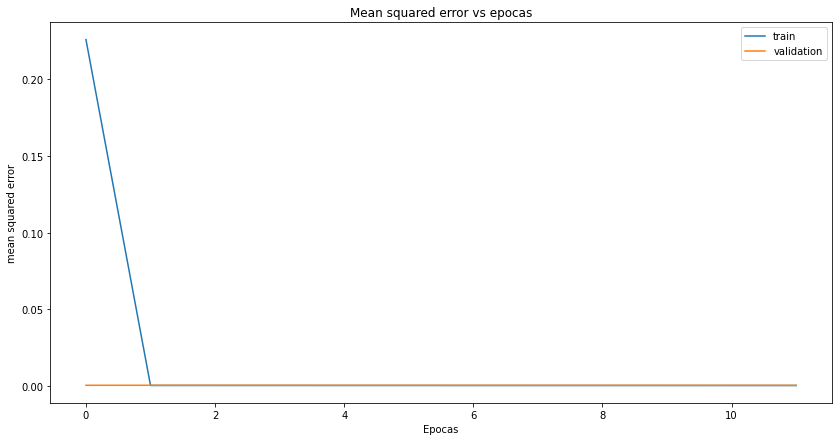

In [309]:
build_nn_for(5, NEURONS=32, LAYERS=2, INPUT_DIM=35, EPOCHS=12, verbose=0)

#<b>TASK:</b> mejorar parametros para el fit de la dimension 5

.sistematizar

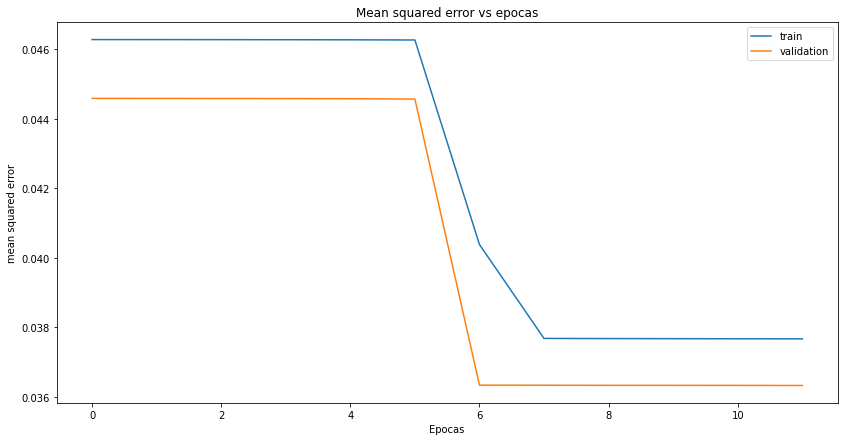

In [312]:
build_nn_for(4, NEURONS=12, LAYERS=3, INPUT_DIM=120, EPOCHS=12, verbose=0)

#<b>TASK:</b> mejorar parametros para el fit de la dimension 4

.sistematizar

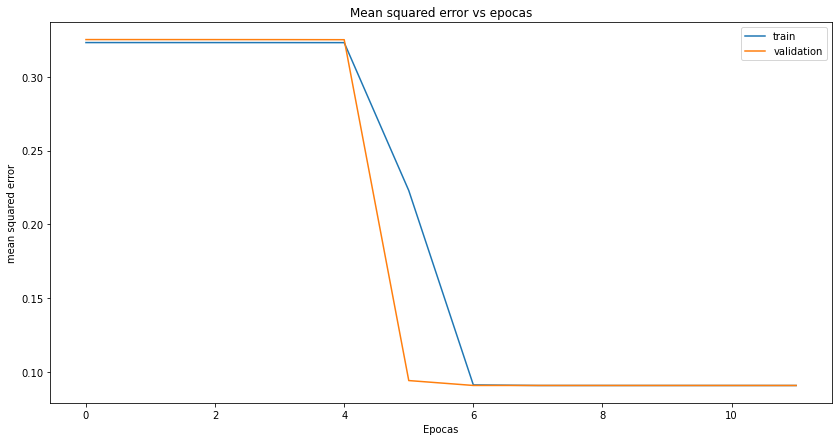

In [314]:
build_nn_for(3, NEURONS=12, LAYERS=1, INPUT_DIM=120, EPOCHS=12, verbose=0)

#<b>TASK:</b> mejorar parametros para el fit de la dimension 3

.no hay mas nada por hacer, conformarse con esto o migrar

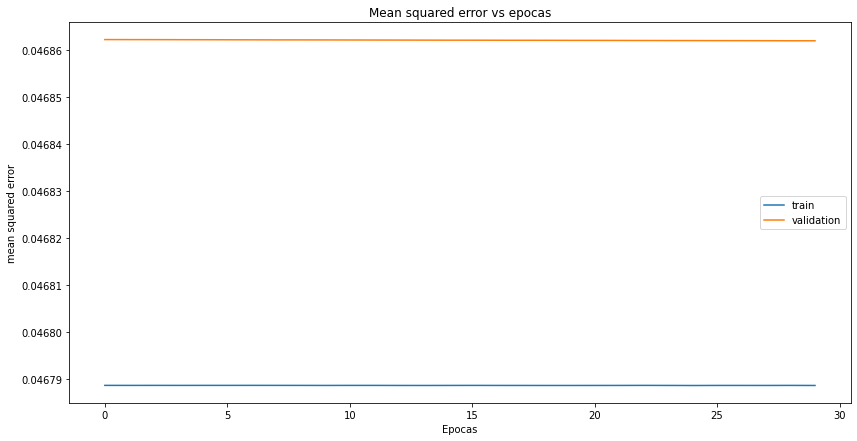

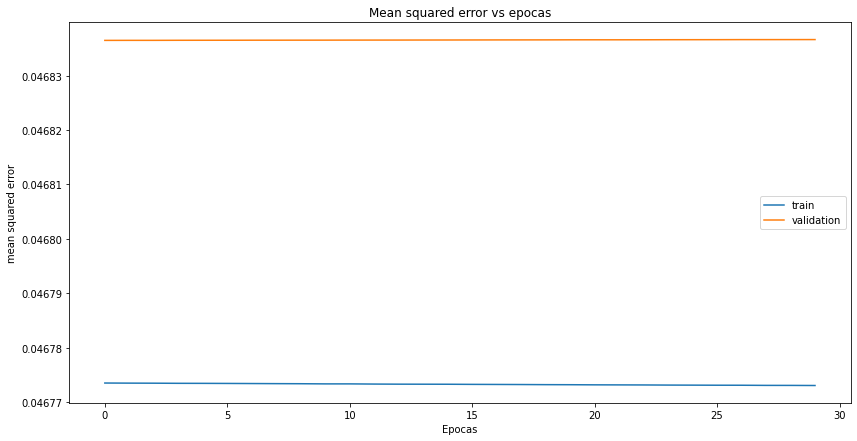

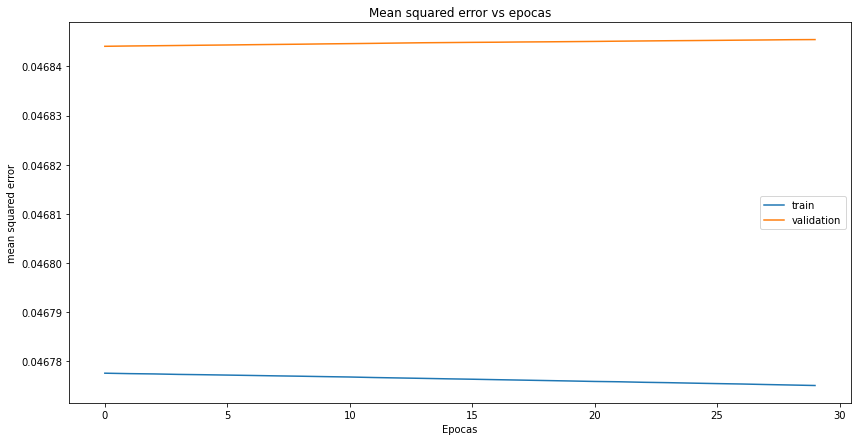

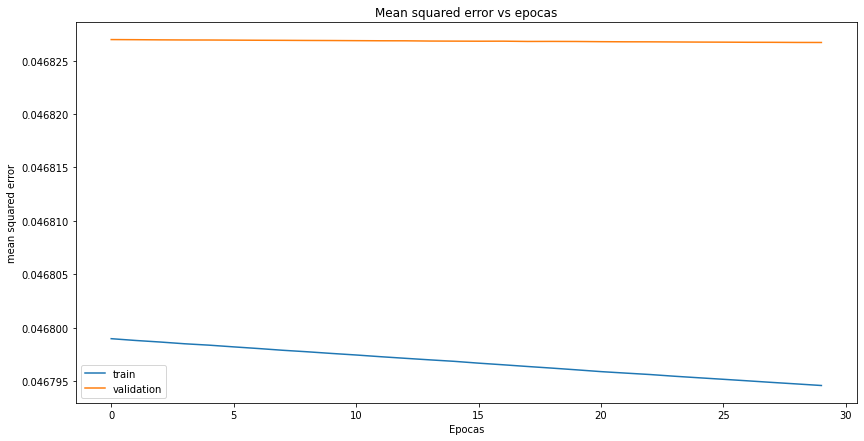

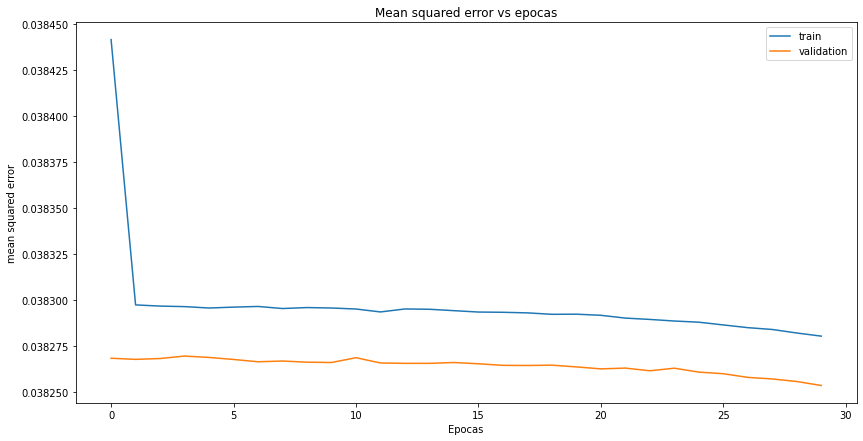

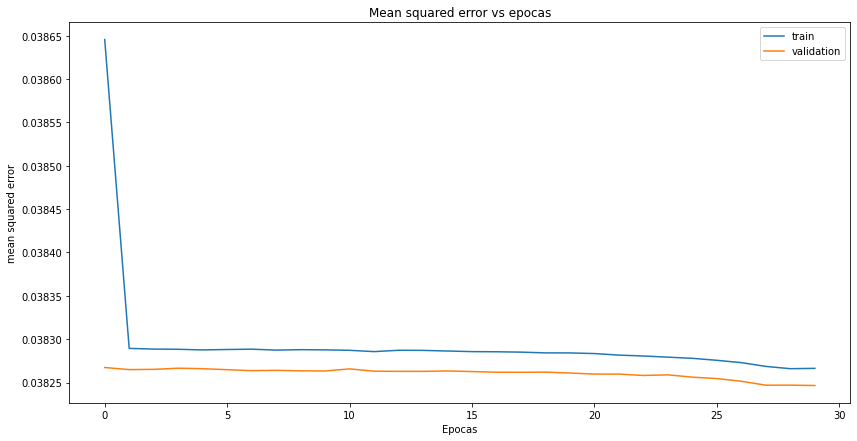

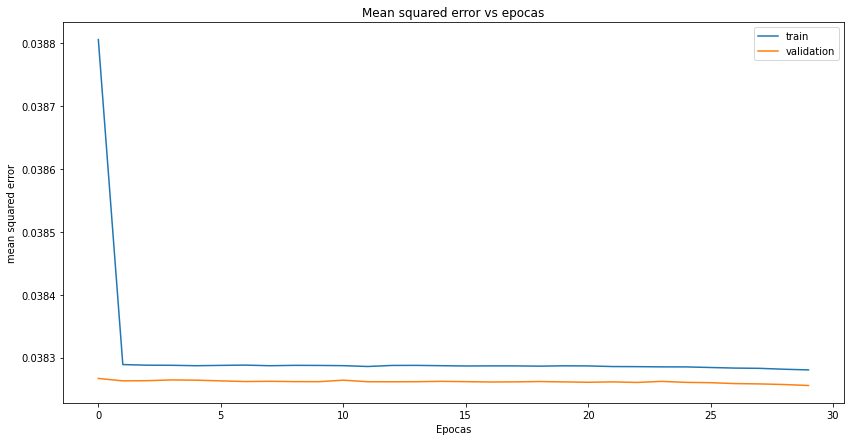

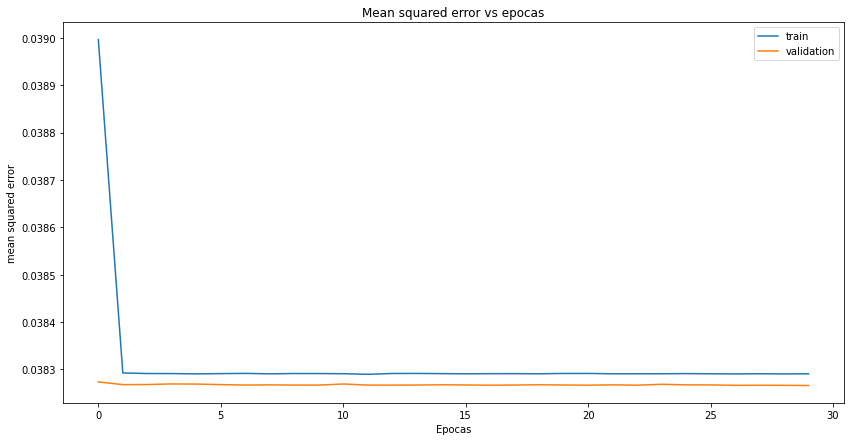

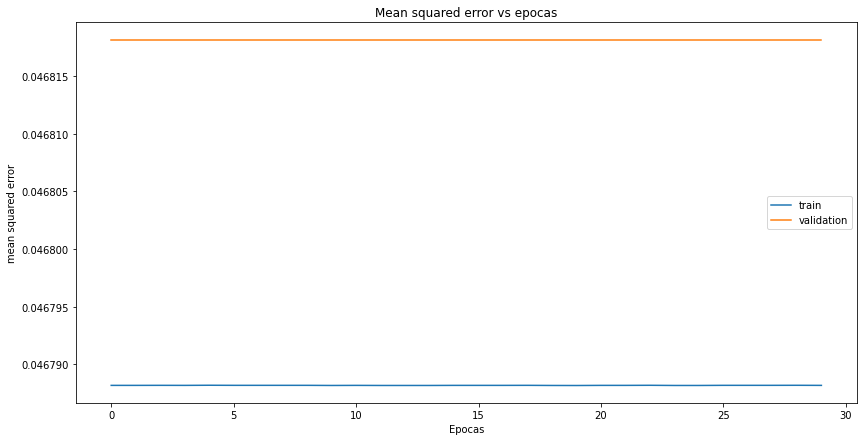

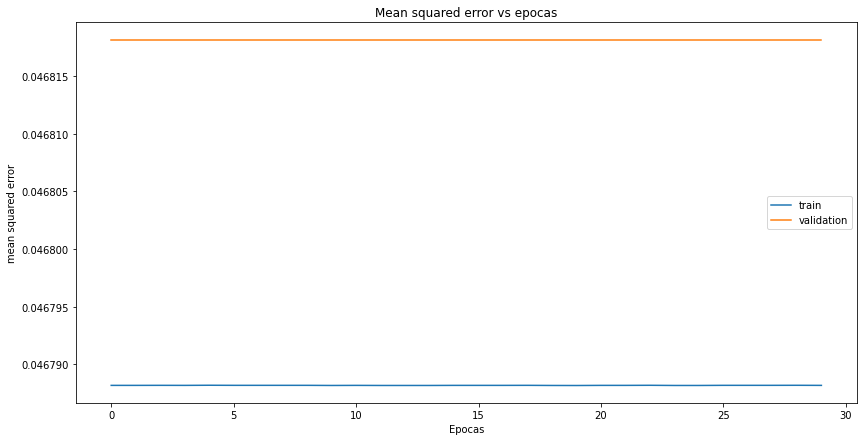

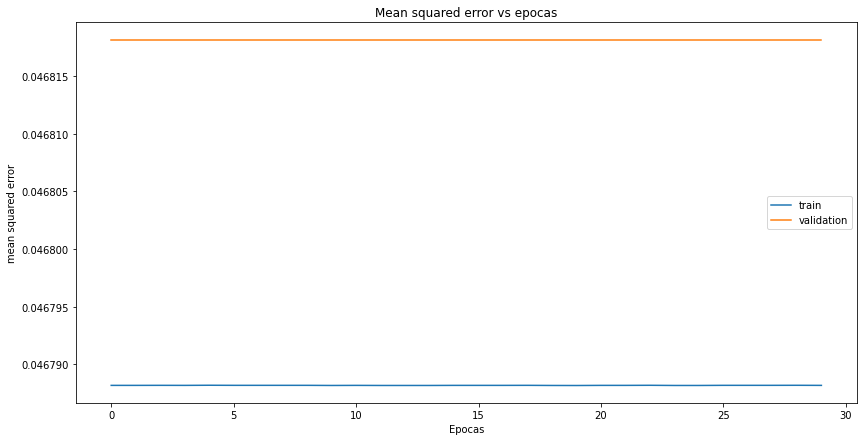

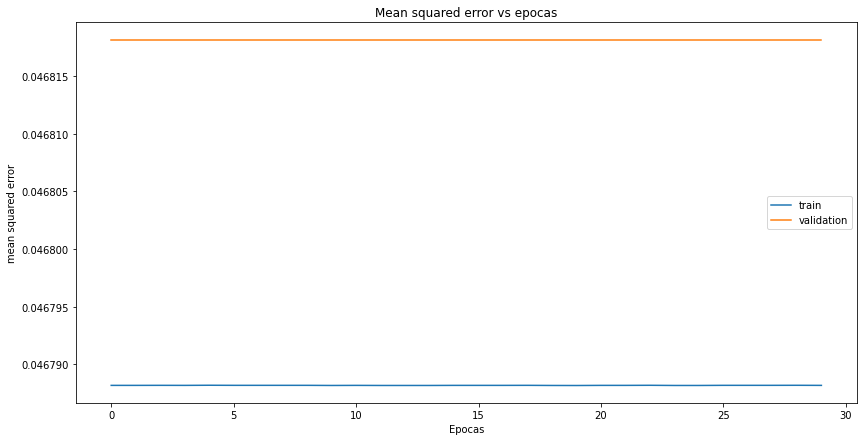

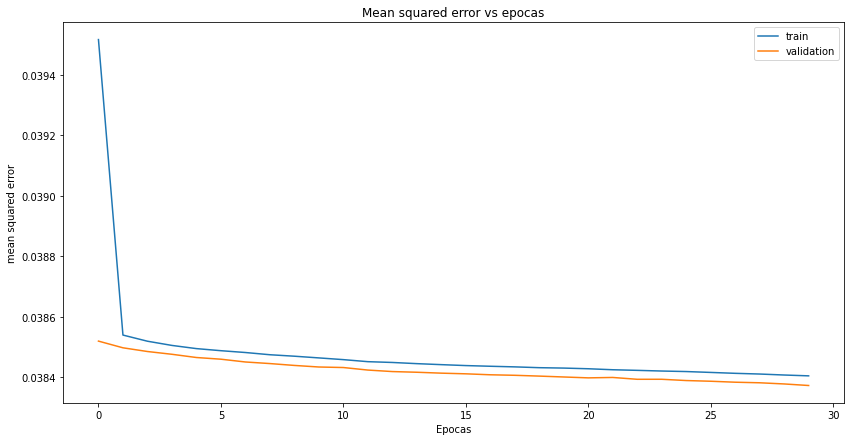

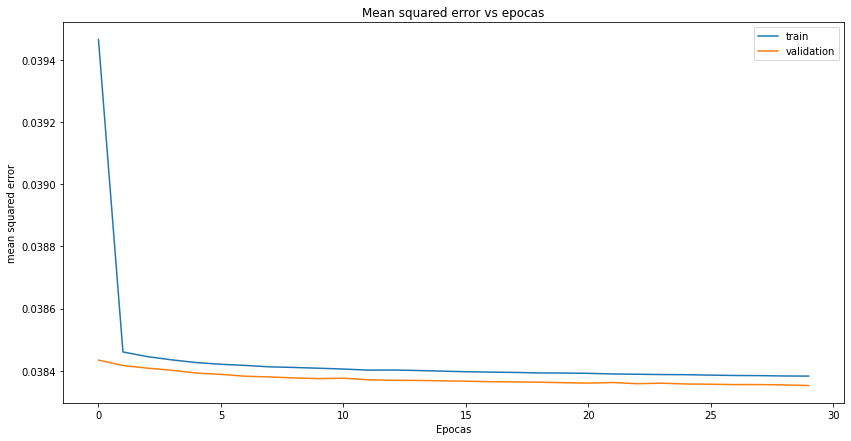

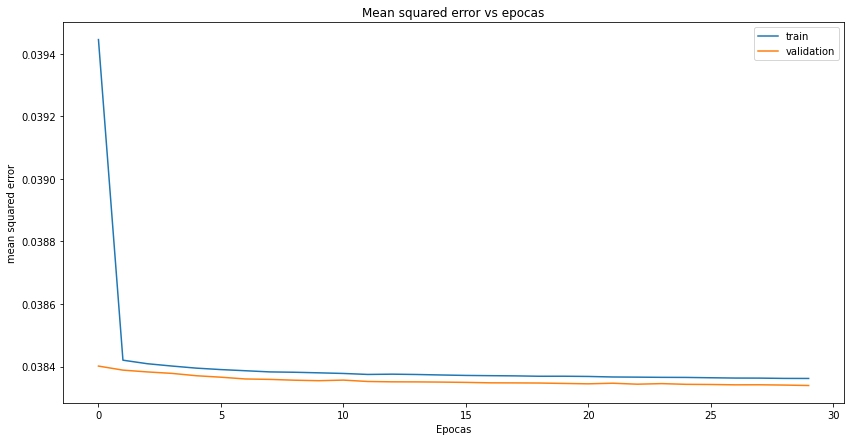

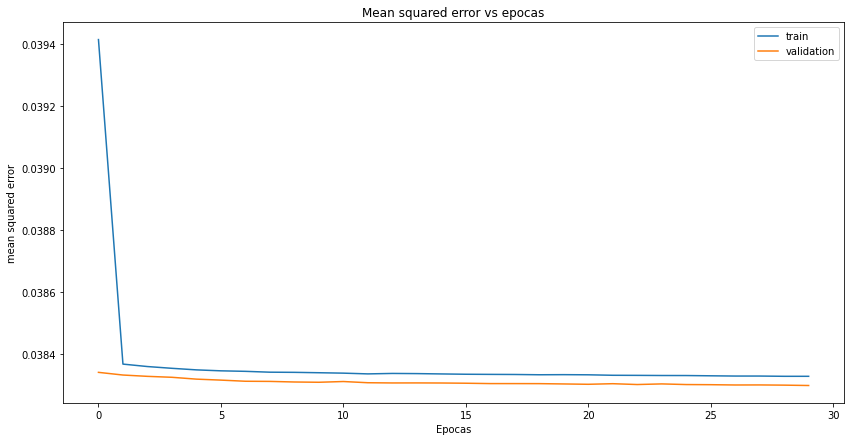

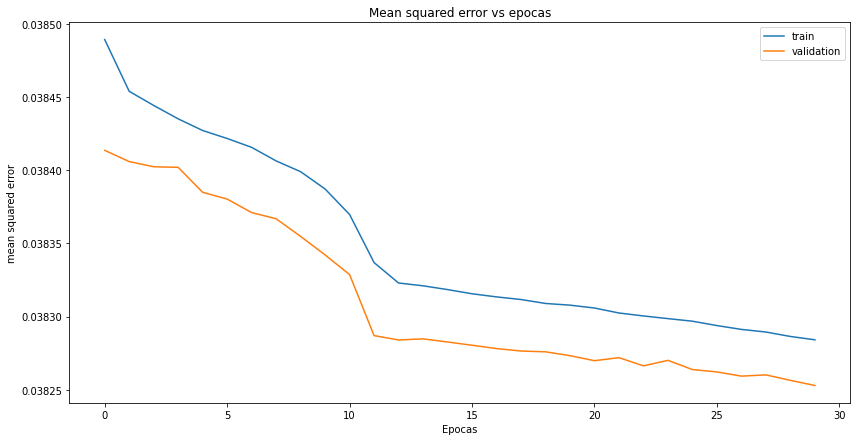

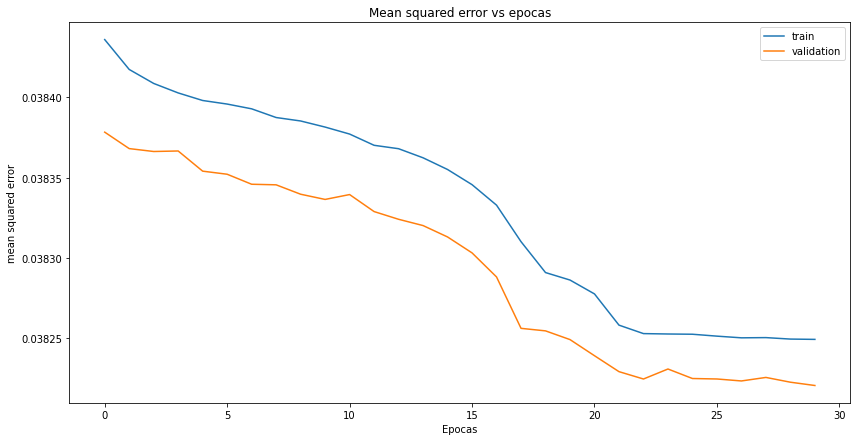

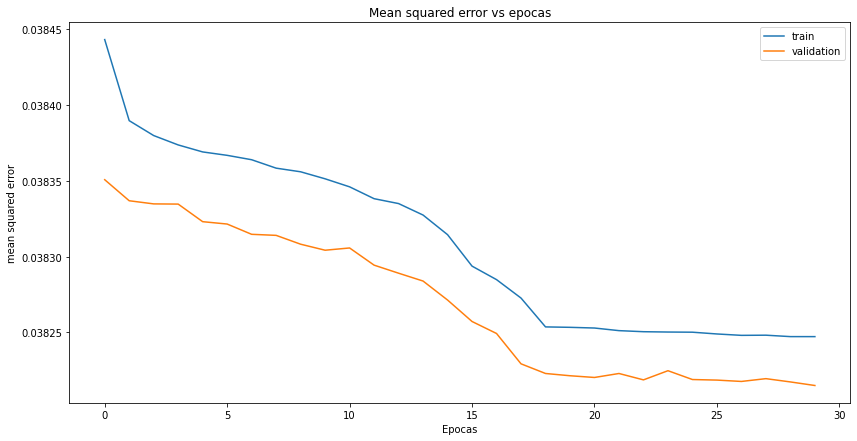

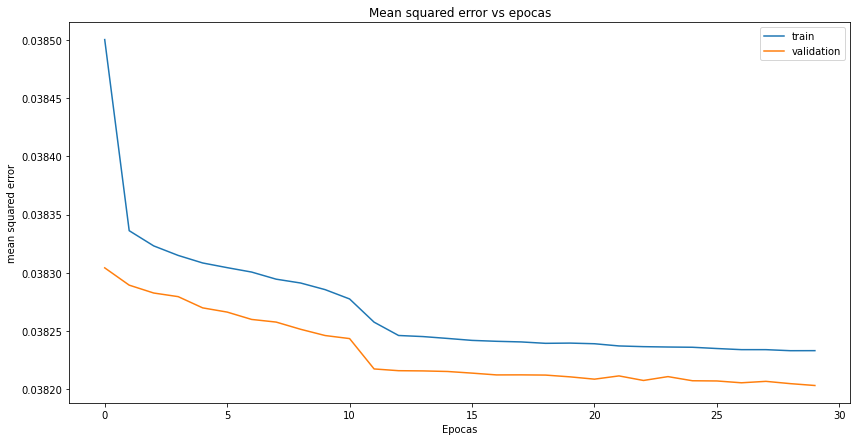

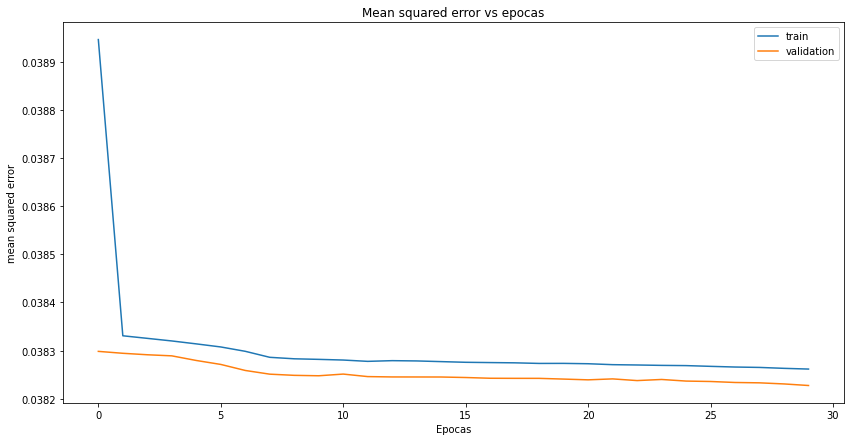

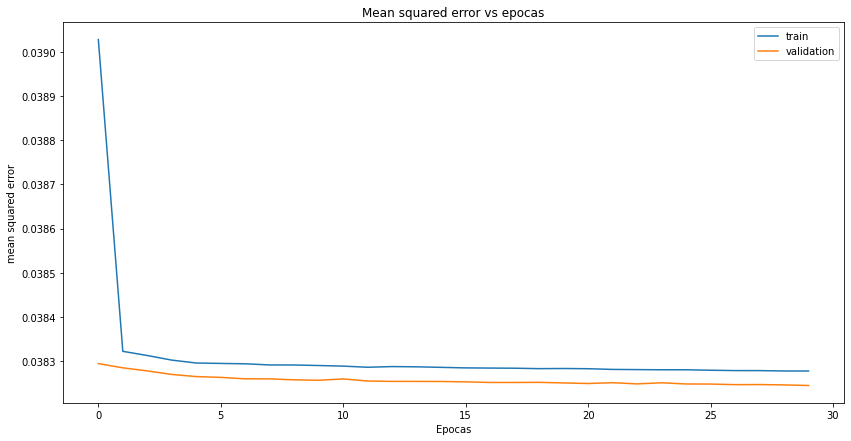

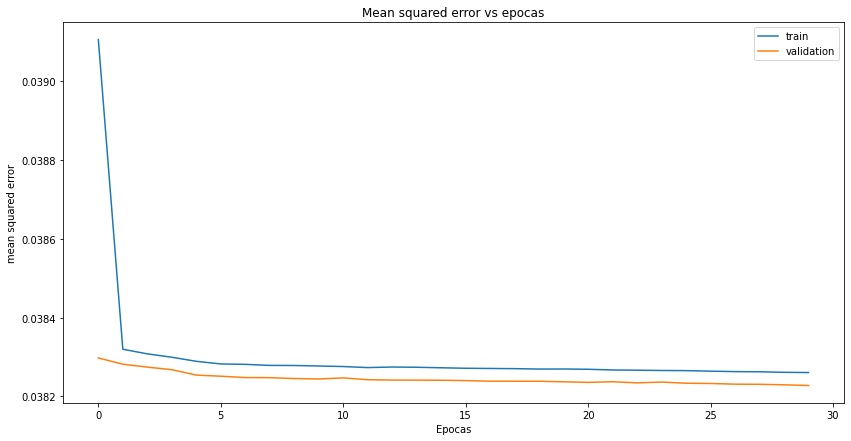

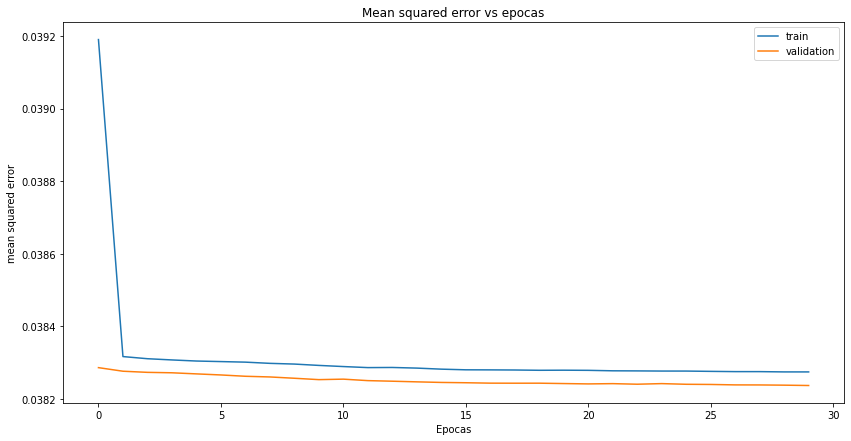

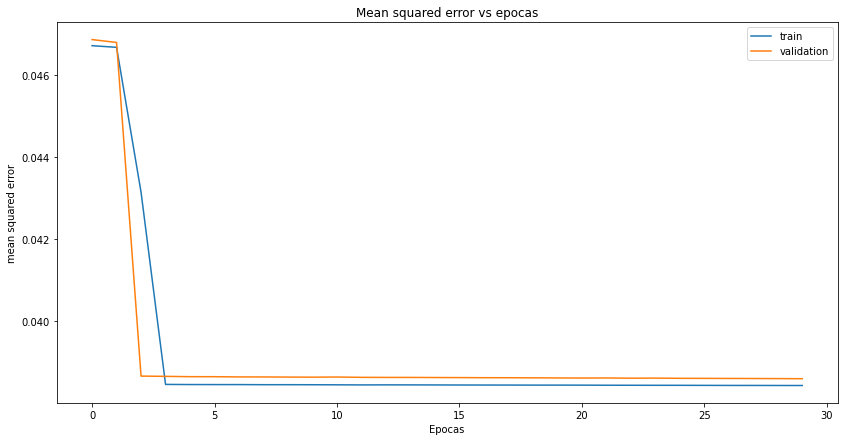

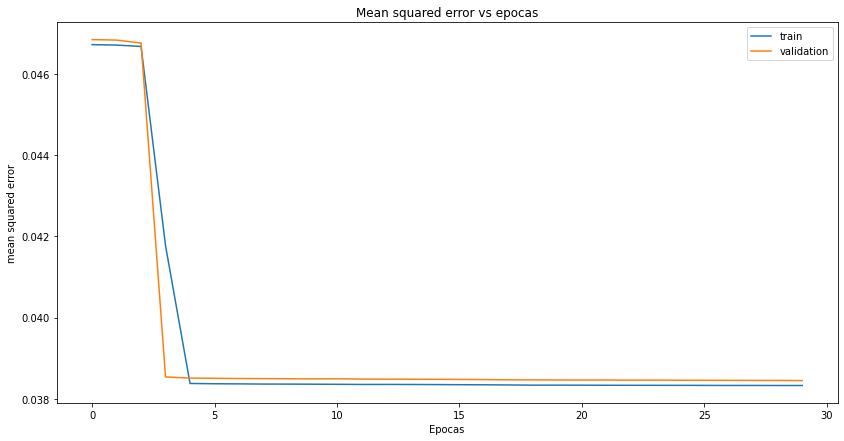

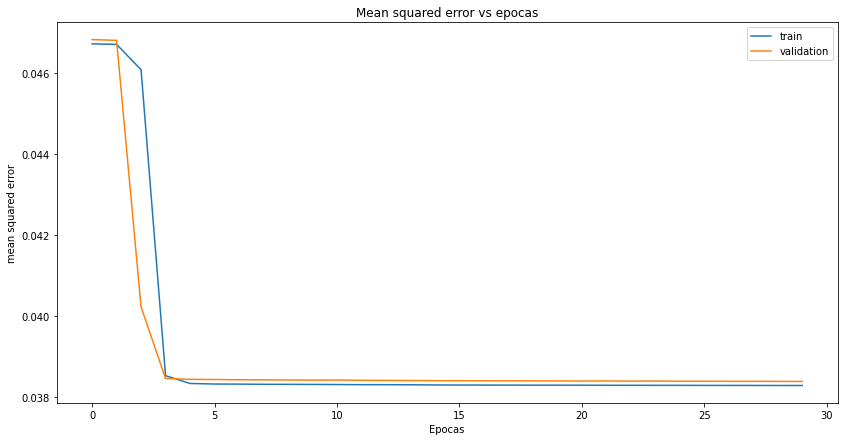

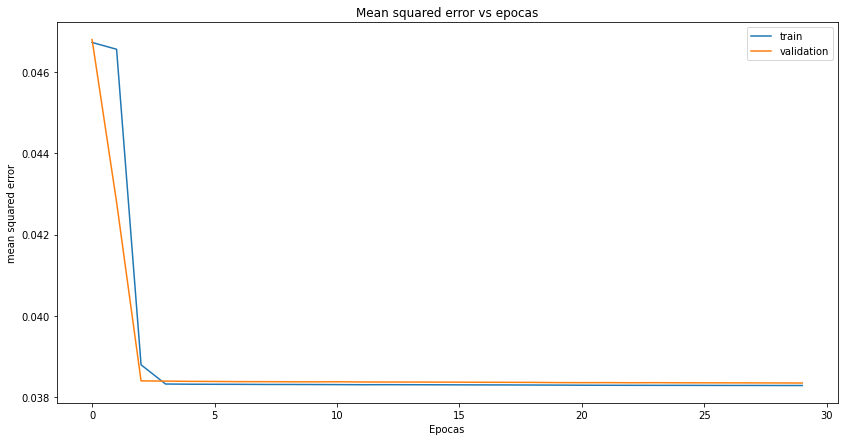

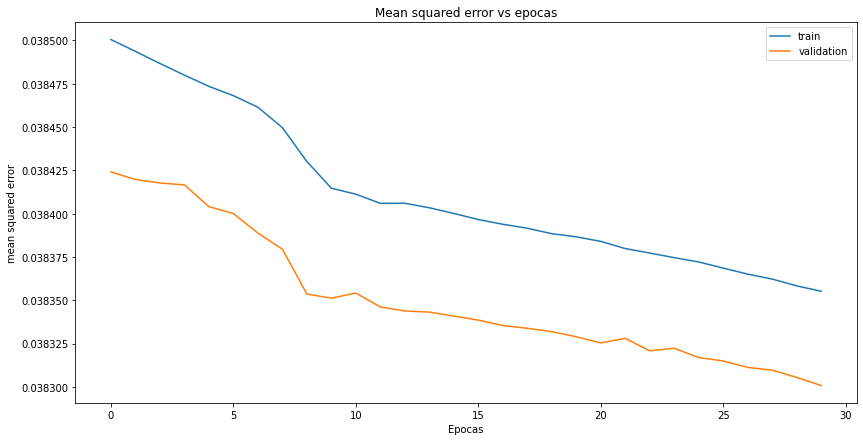

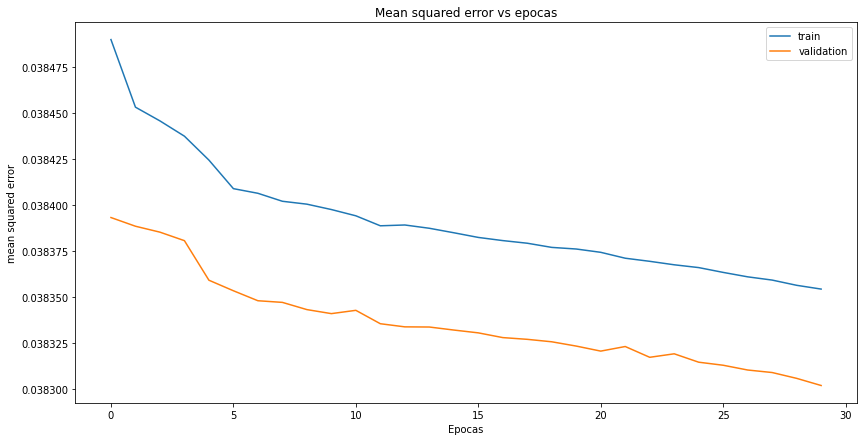

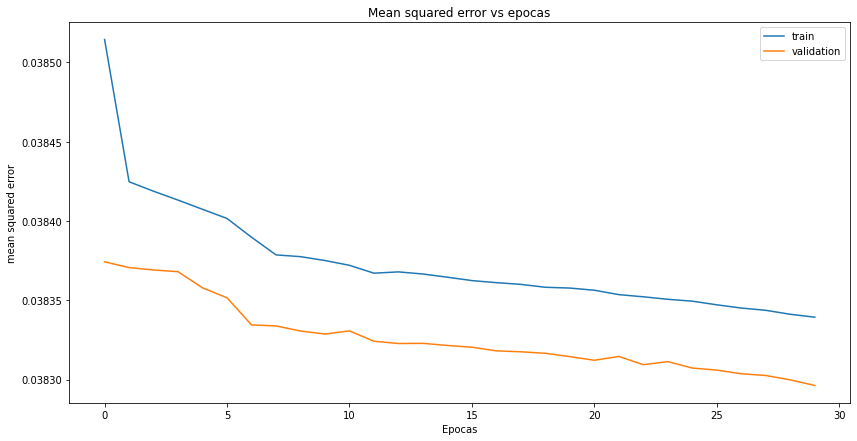

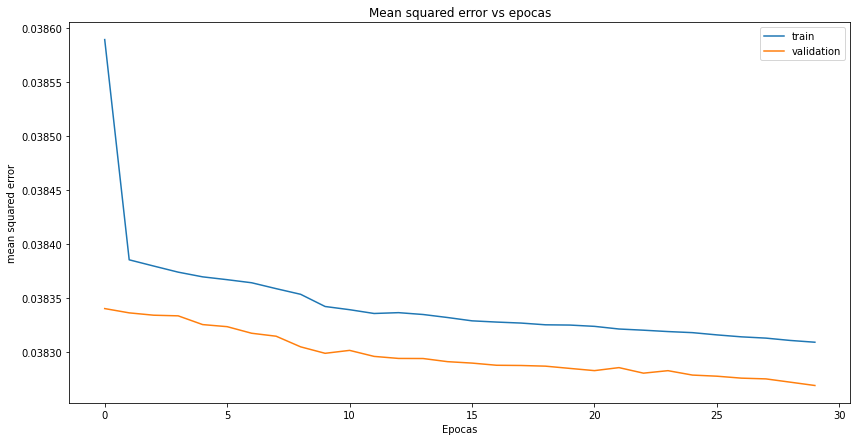

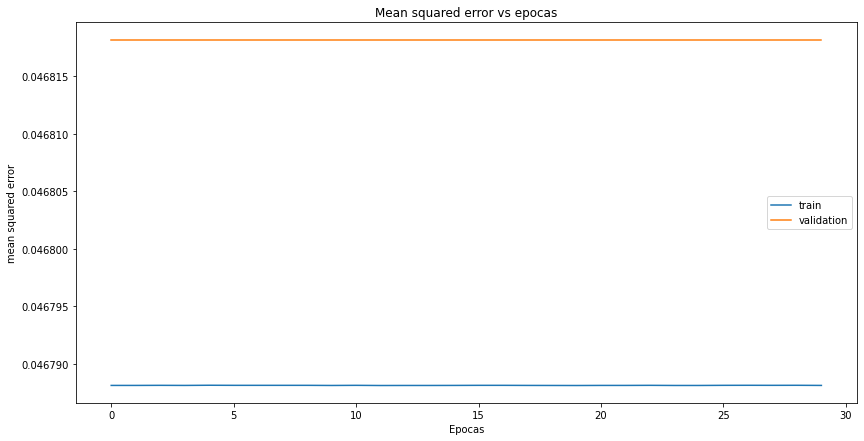

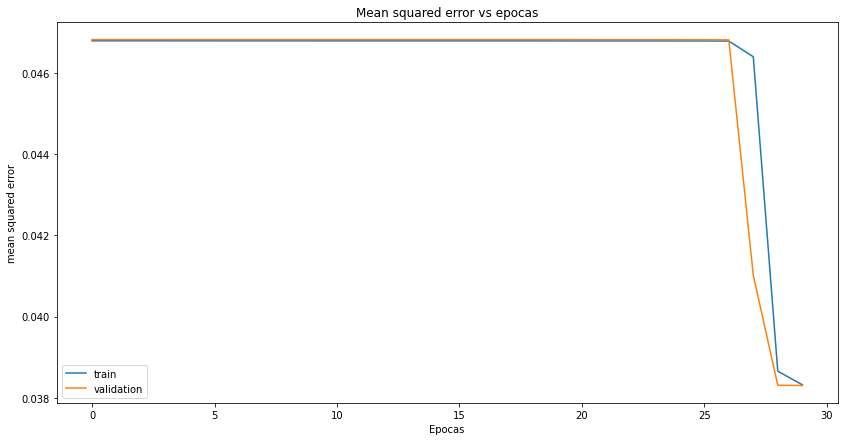

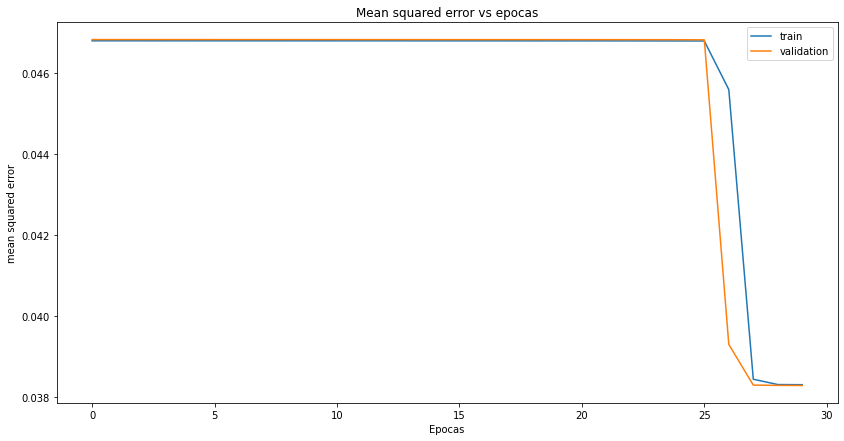

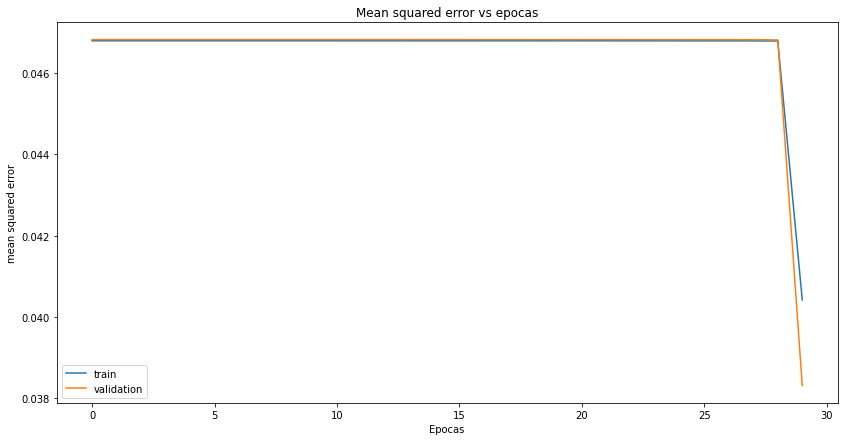

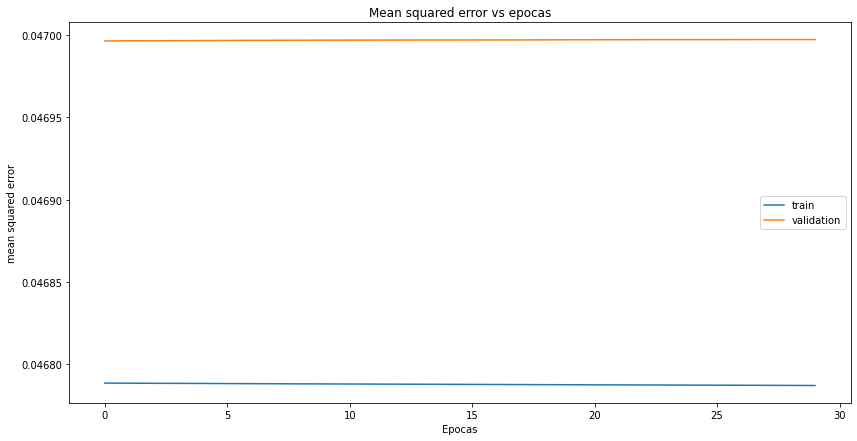

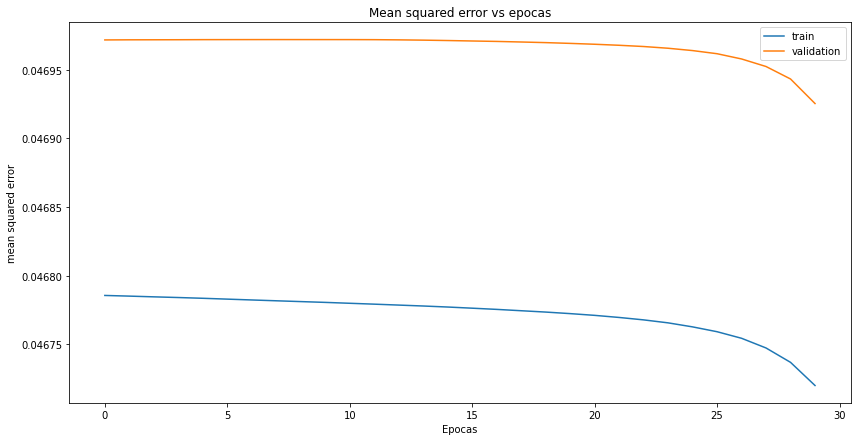

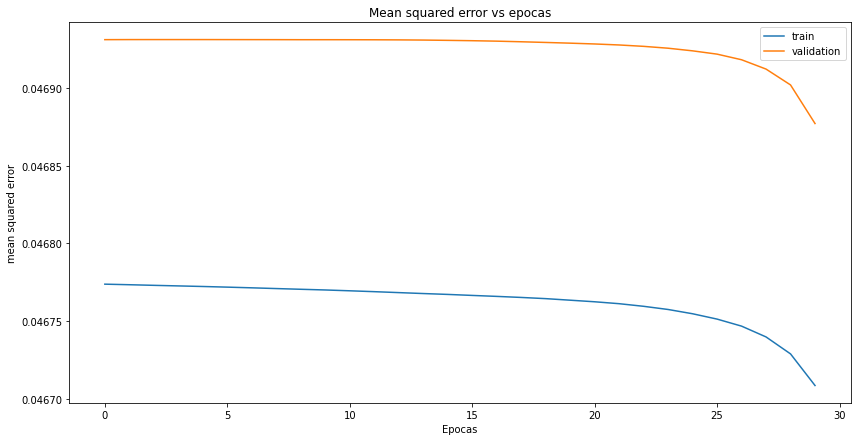

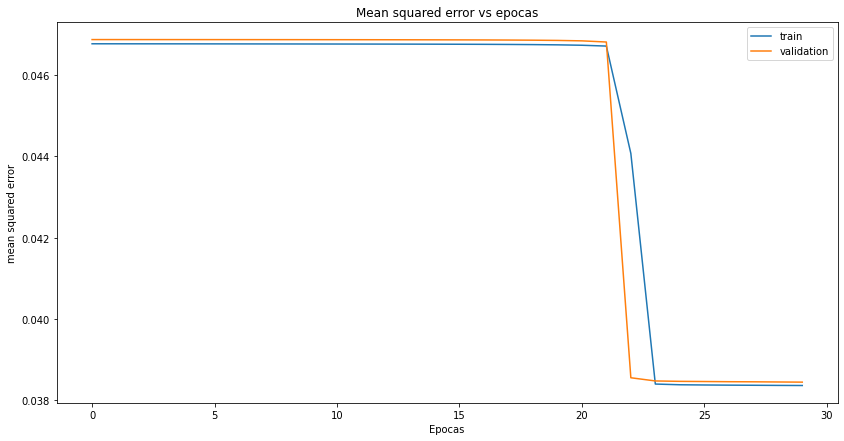

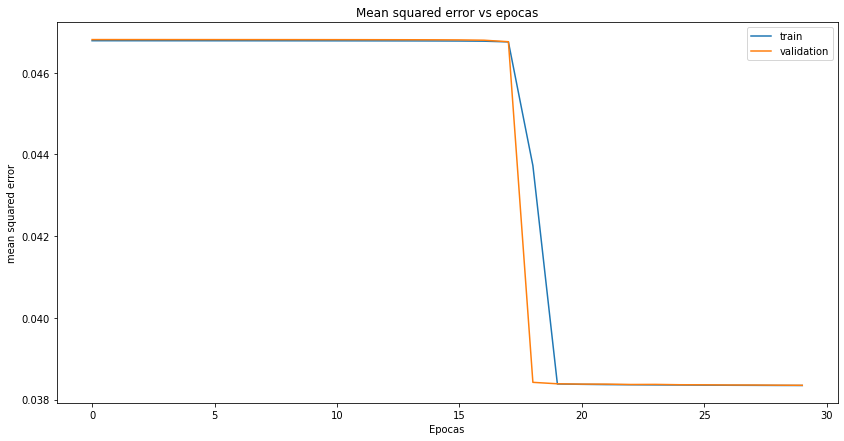

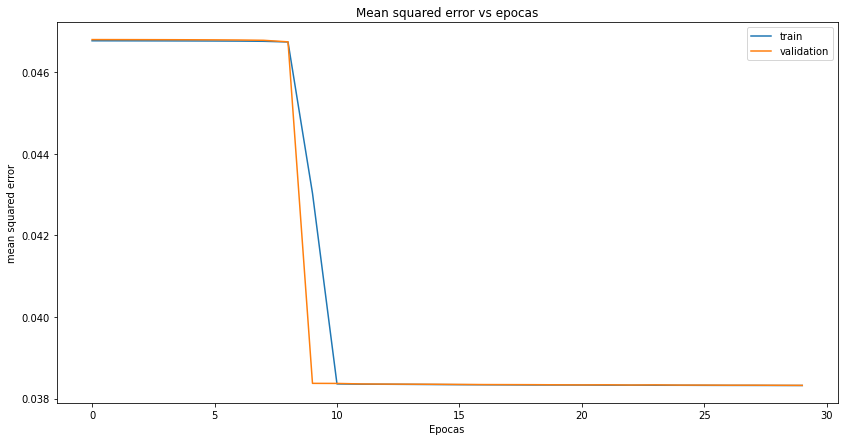

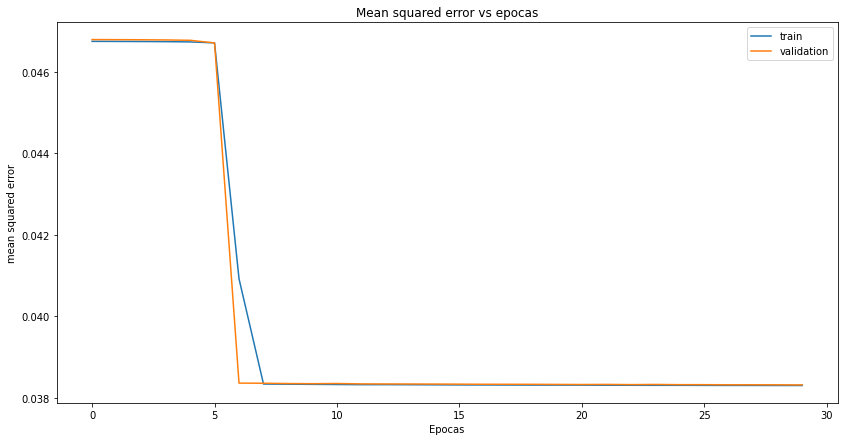

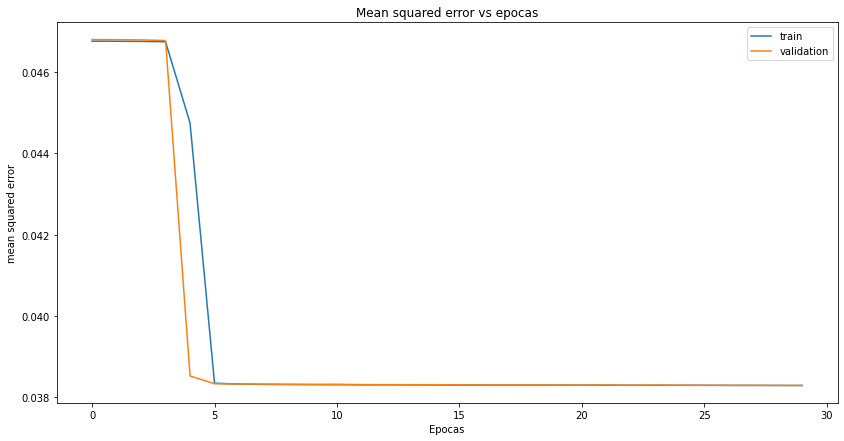

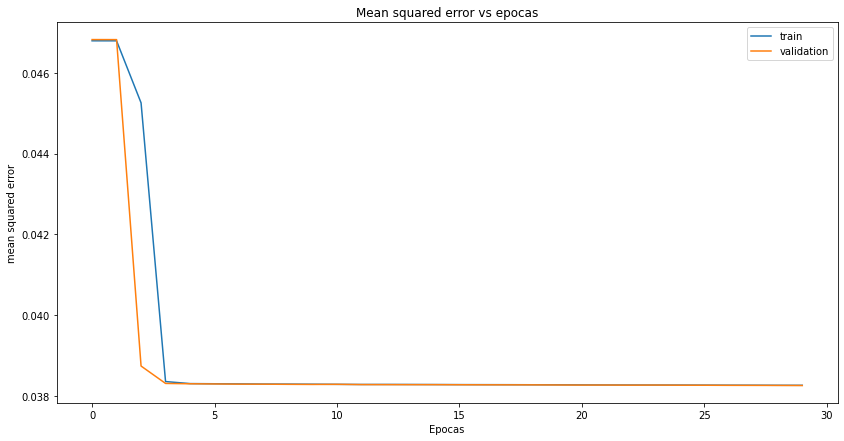

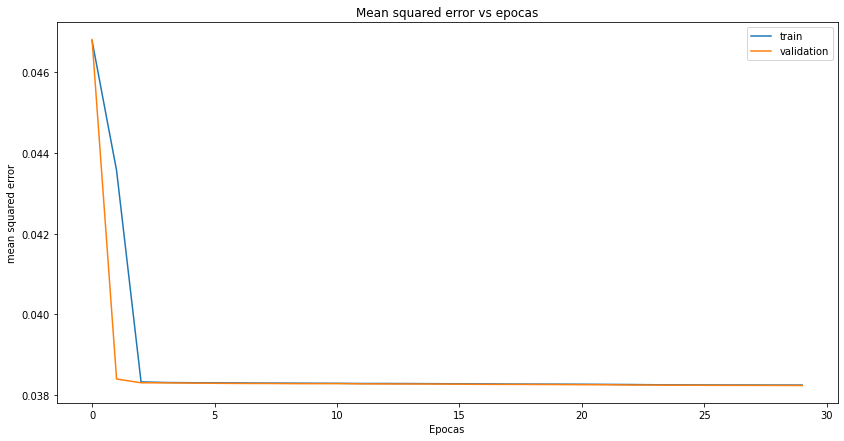

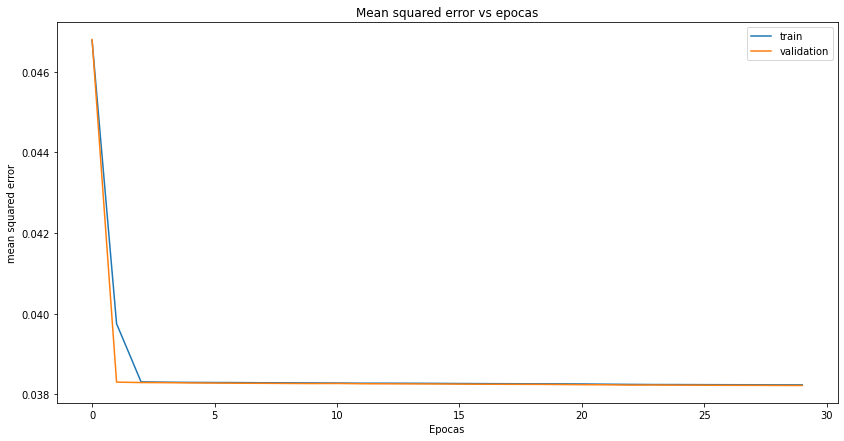

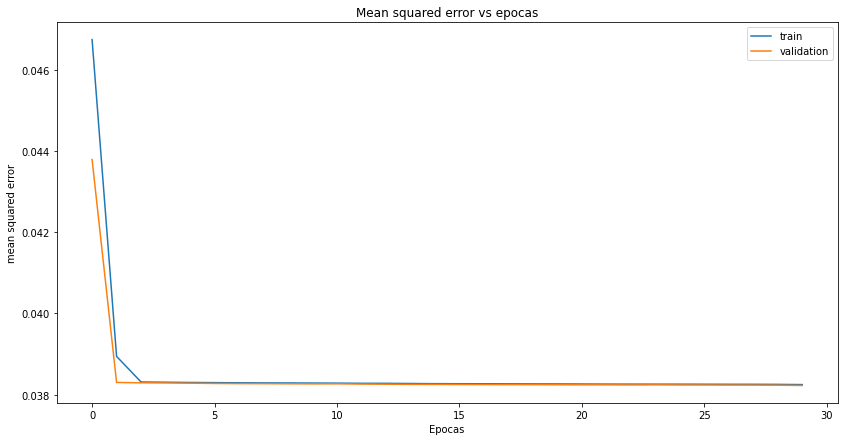

In [345]:
history_for_3 = {}
for nr in [4,16,32,64]:
  for ll in [1,2,4]:
    for id in [30,60,100,200]:
      reset_random_seeds()
      history_for_3[(nr,ll,id)] = build_nn_for(2, NEURONS=nr, LAYERS=ll, INPUT_DIM=id, EPOCHS=30, verbose=0)

In [346]:
trainlosses, vallosses = zip(*list(history_for_3.values()))
print('MIN TRAINING LOSS WAS', min(trainlosses))
print('MIN VAL LOSS WAS', min(vallosses))

MIN TRAINING LOSS WAS 0.03615812212228775
MIN VAL LOSS WAS 0.035634513944387436


In [350]:
a,b,c = zip(*list(history_for_3.keys()))

In [369]:
X.shape

(3, 4)

In [373]:
X.shape, Y.shape, Z.shape, w.shape

((3, 4), (3, 4), (4, 3), (4, 3))

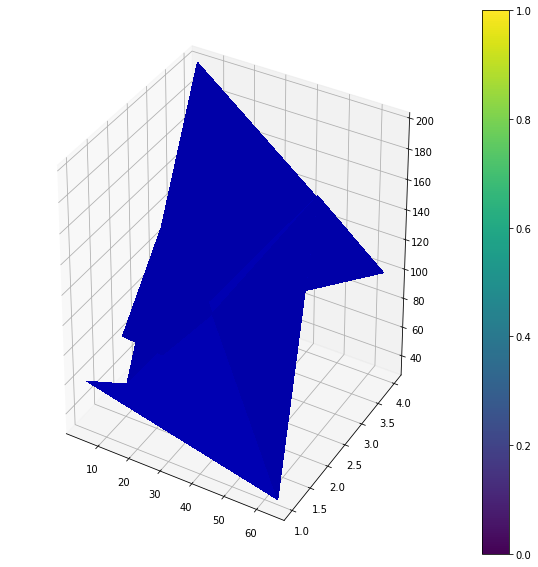

In [381]:
w = []
c_ = c[0]
for a_ in set(a):
  for b_ in set(b):
    w.append(history_for_3[(a_,b_,c_)][0])
w = np.asarray(z).reshape(len(set(a)), len(set(b))).T

# Python-matplotlib Commands
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')#, rotate=30)
X = np.asarray(list(set(a)))
Y = np.asarray(list(set(b)))
X, Y = np.meshgrid(X, Y)
Z = np.asarray(list(set(c))*len(set(b))).reshape(len(set(a)), len(set(b))).T

surf = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1,
    facecolors=cm.jet(w),
    linewidth=0, antialiased=False, shade=False,
    vmin=vmin, vmax=vmax)
cbar = fig.colorbar(surf)
vmin=np.min(w)
vmax=np.max(w)
cbar.set_clim(vmin, vmax)
plt.show()


#<b>TASK:</b> mejorar parametros para el fit de la dimension 2

.no hay mas nada por hacer, conformarse con esto o migrar

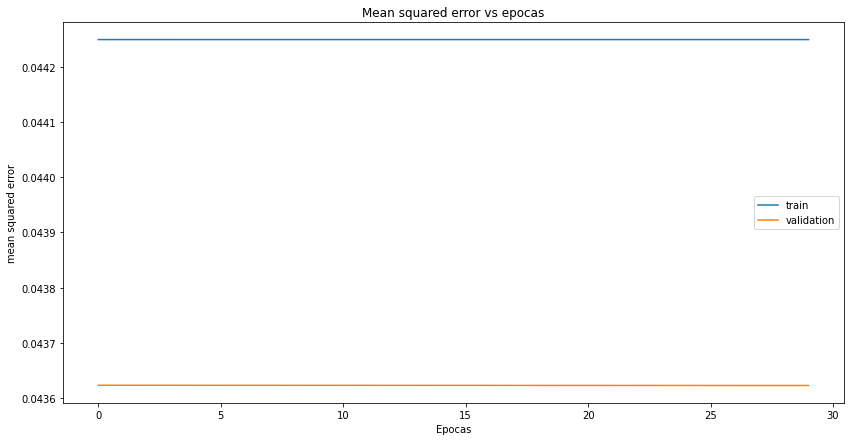

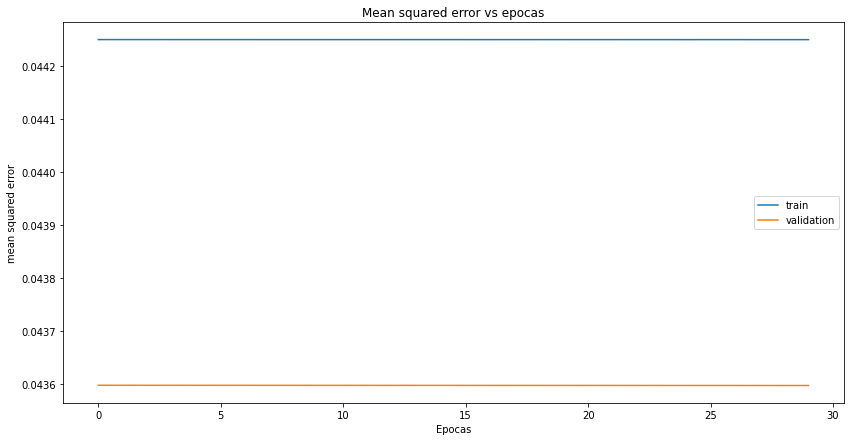

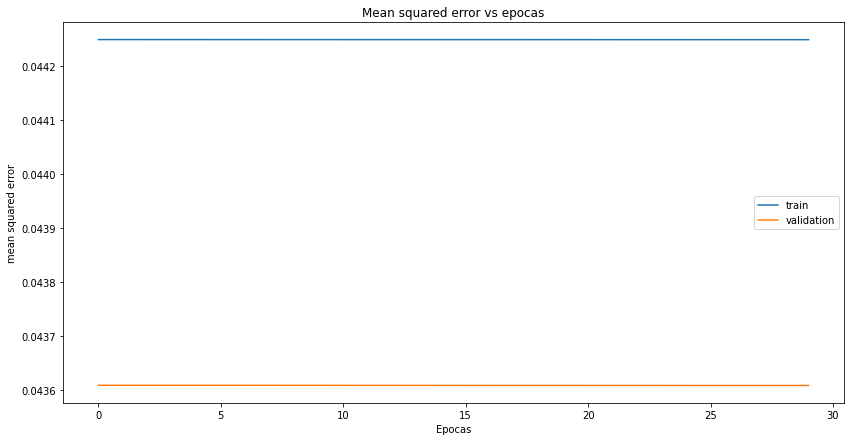

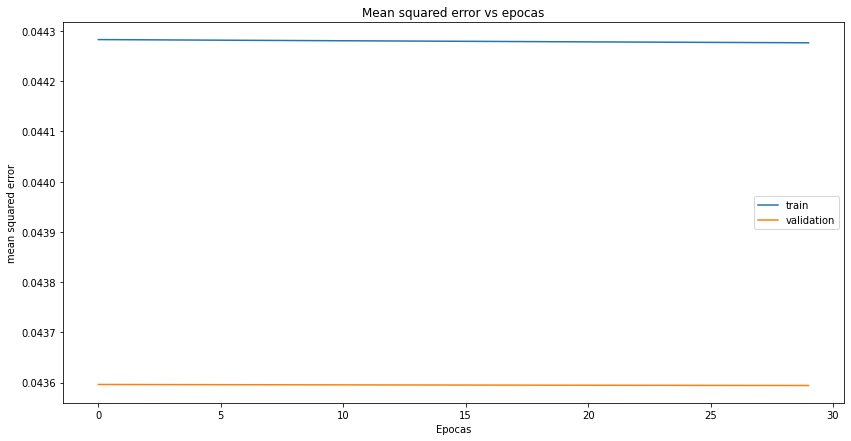

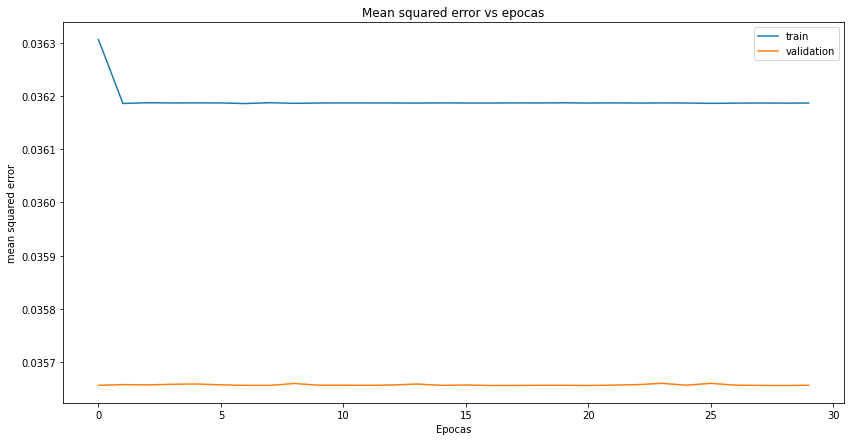

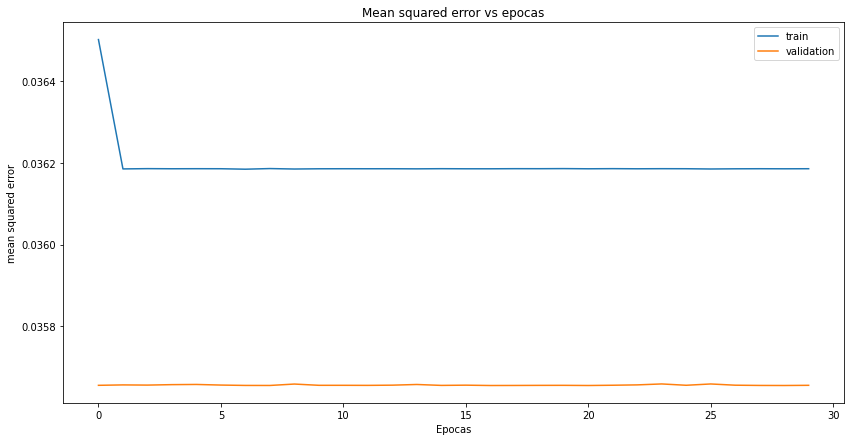

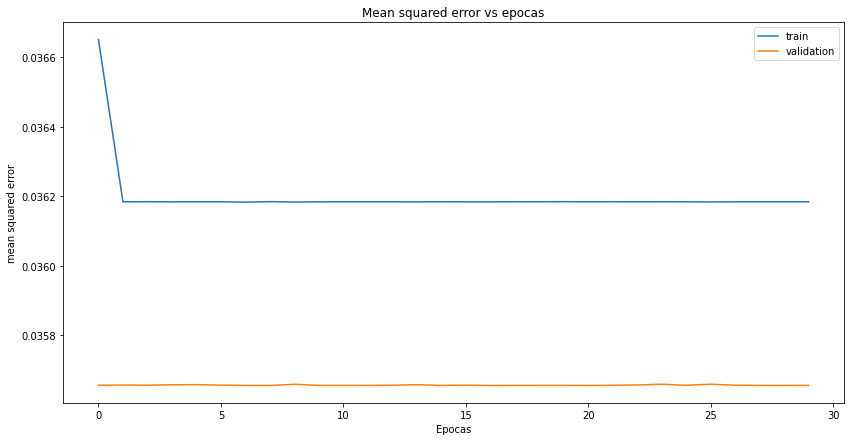

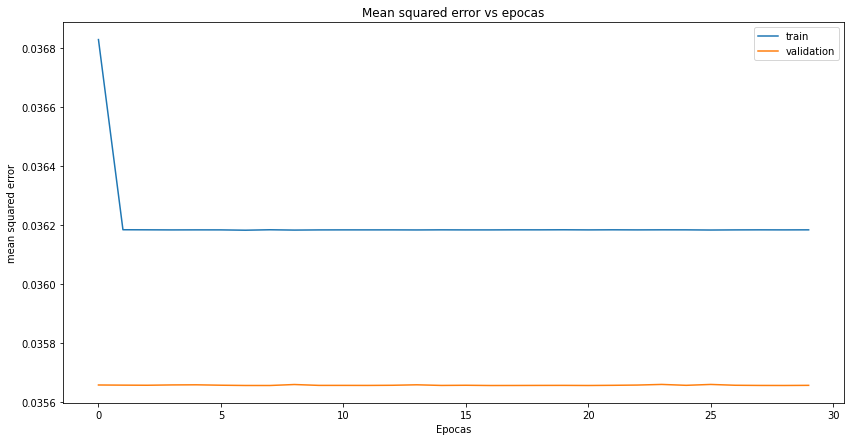

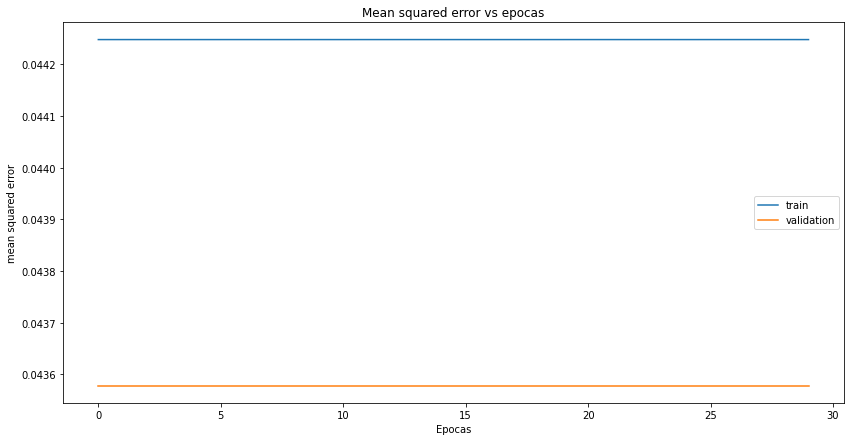

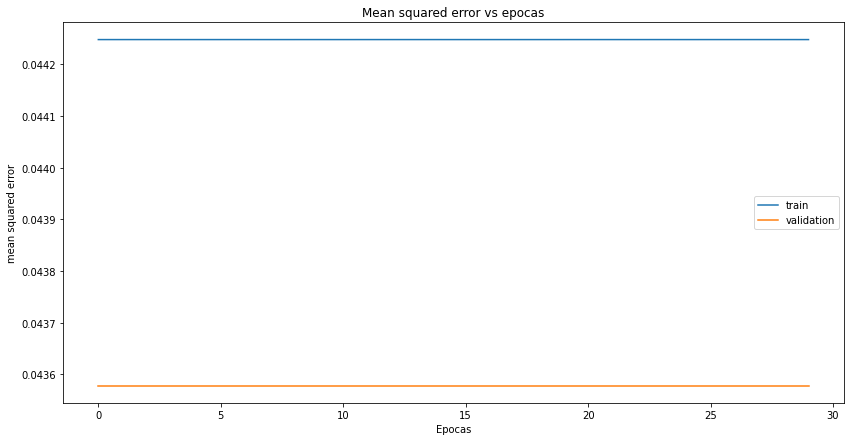

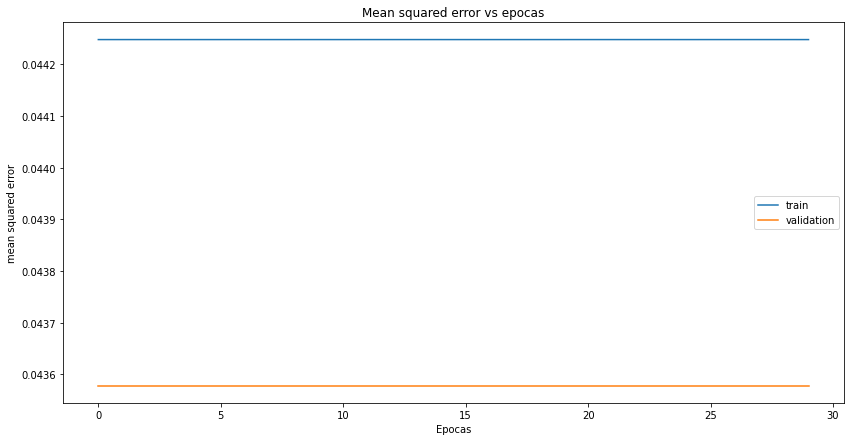

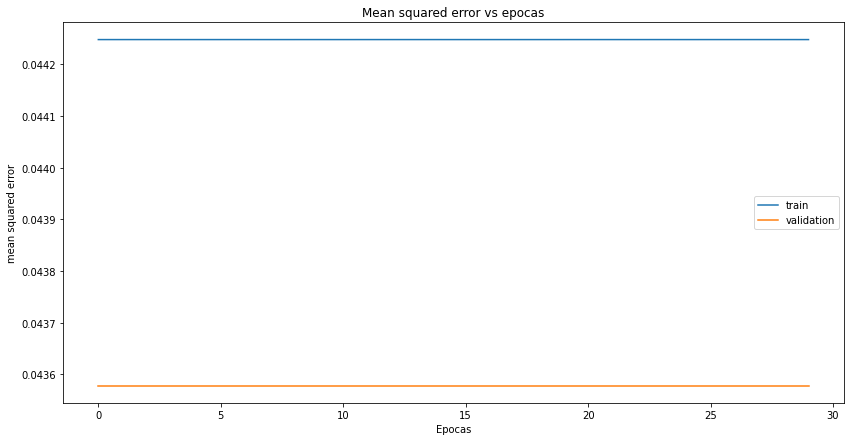

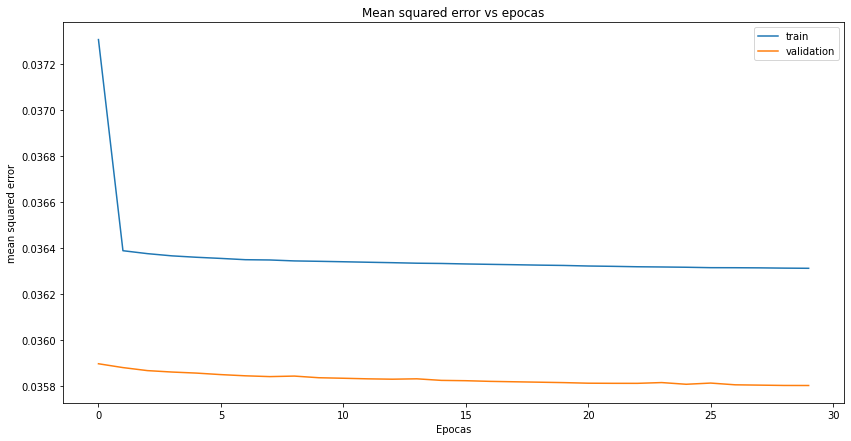

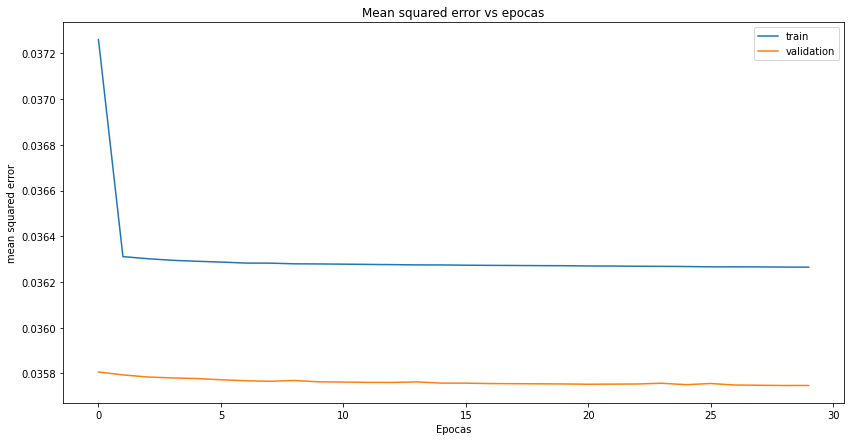

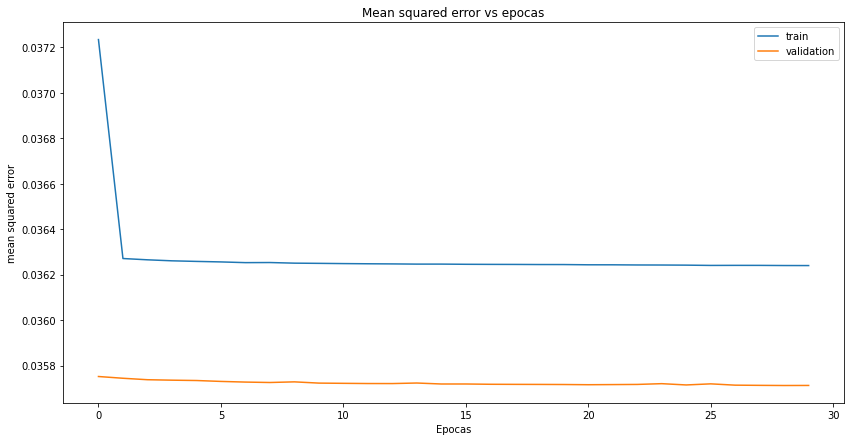

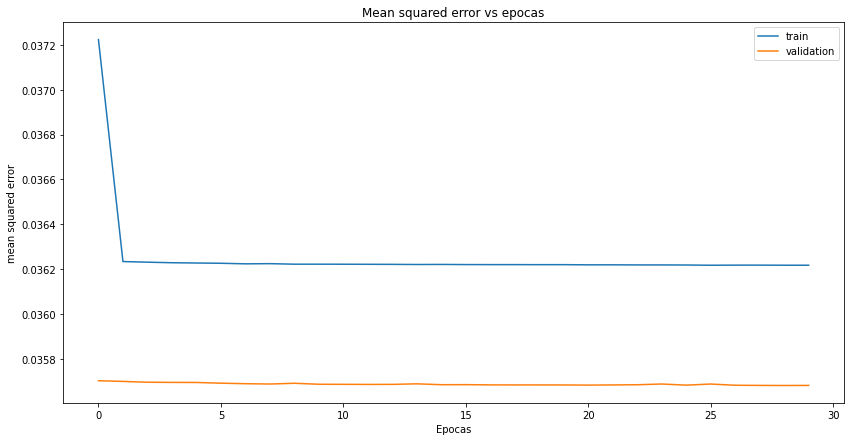

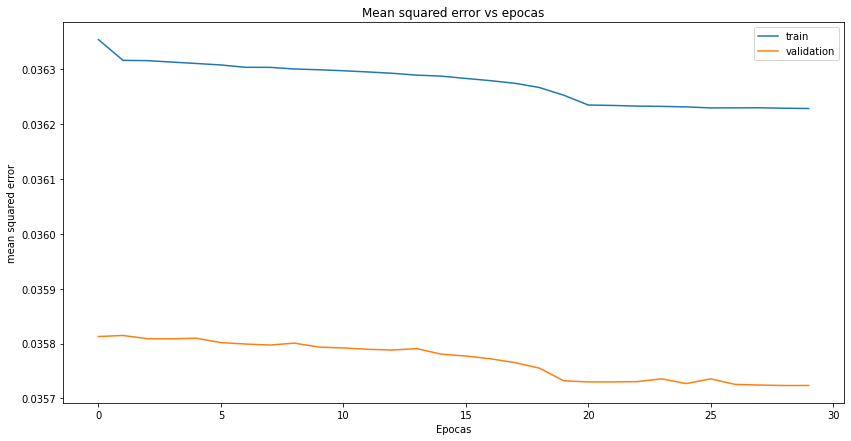

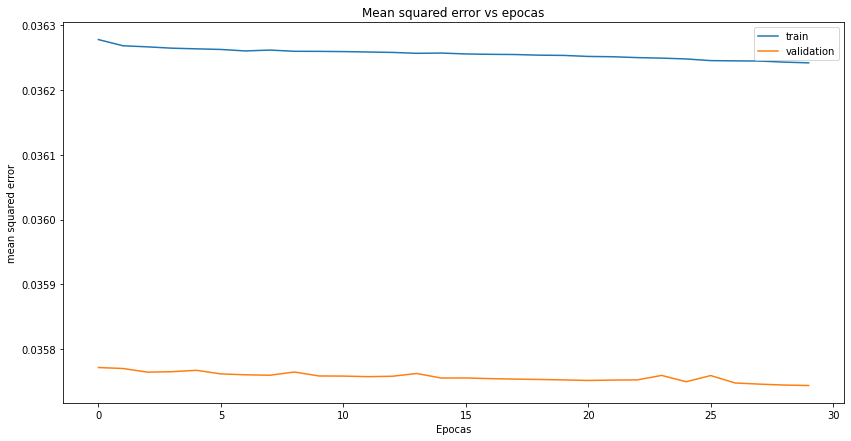

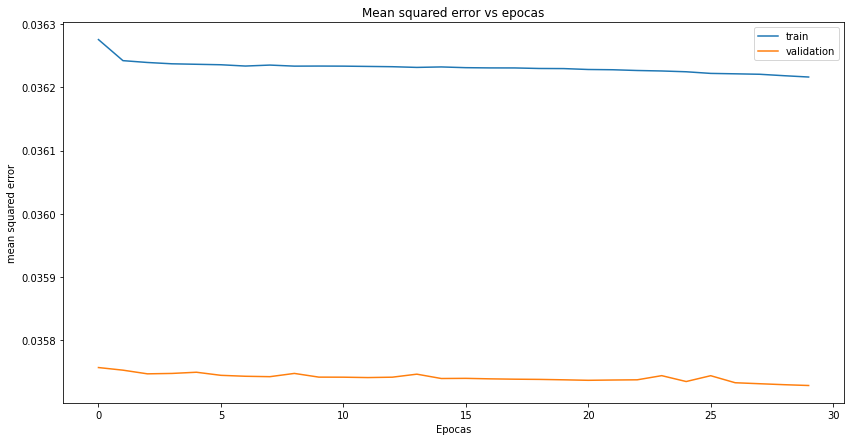

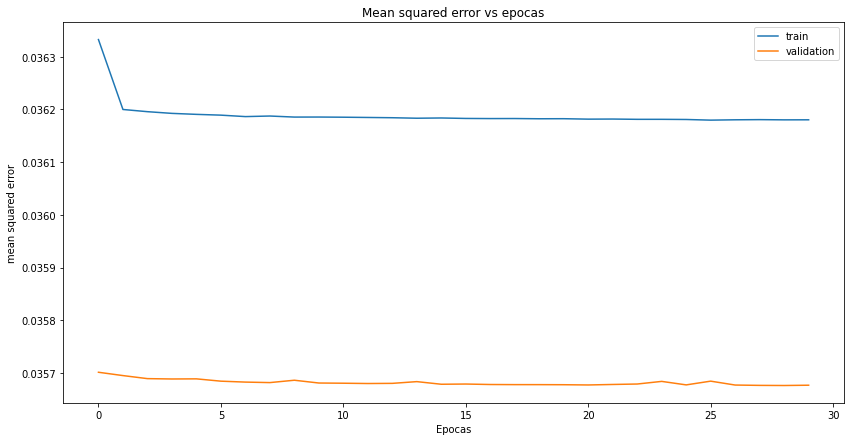

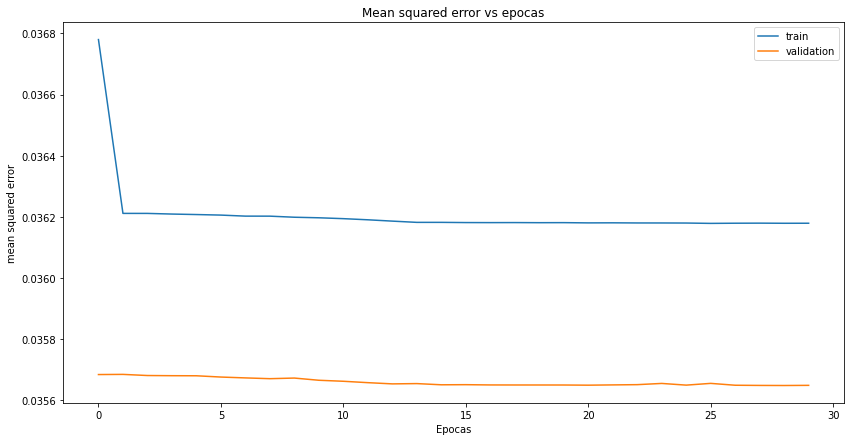

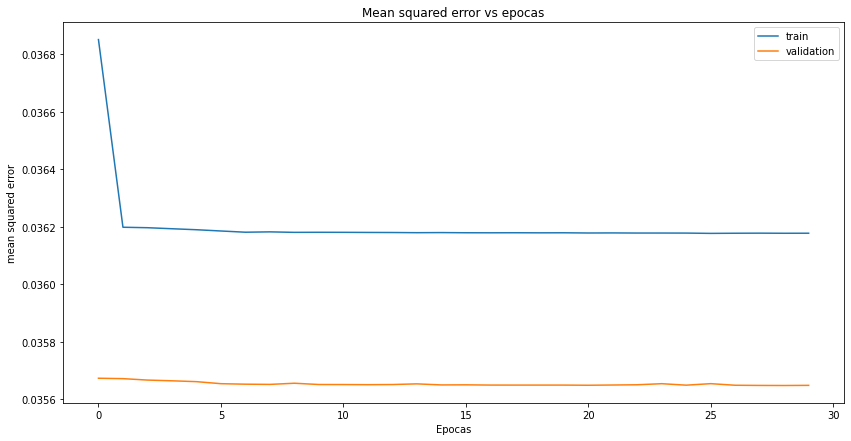

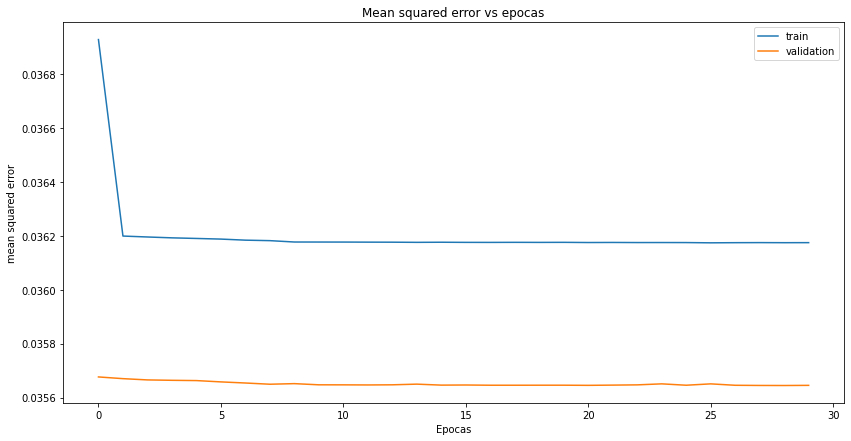

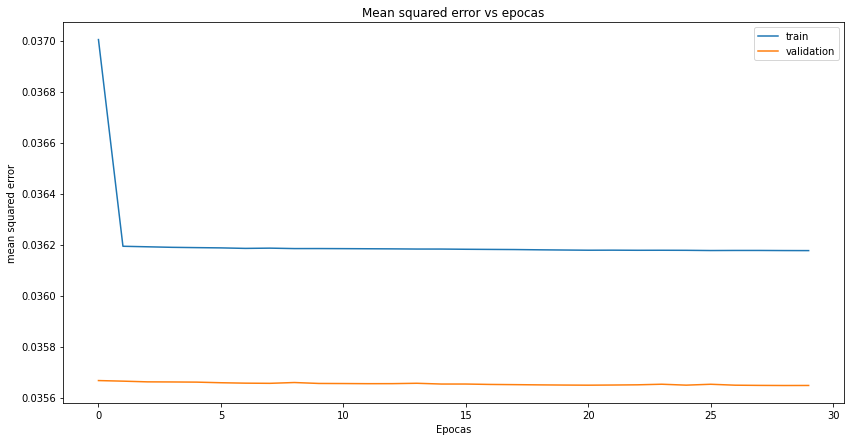

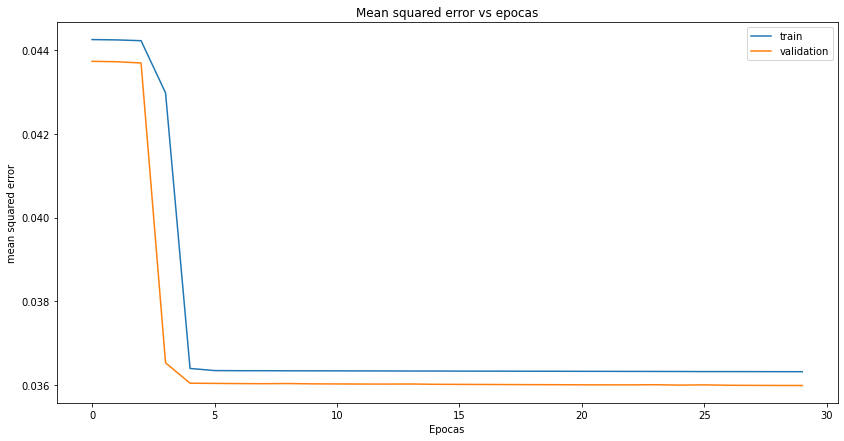

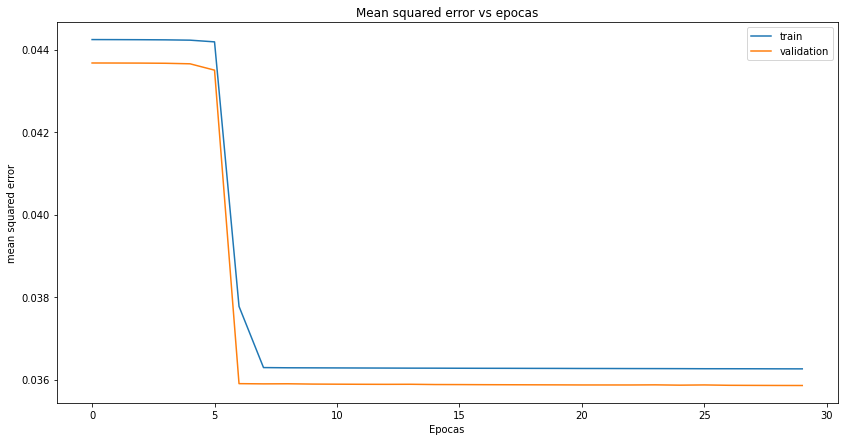

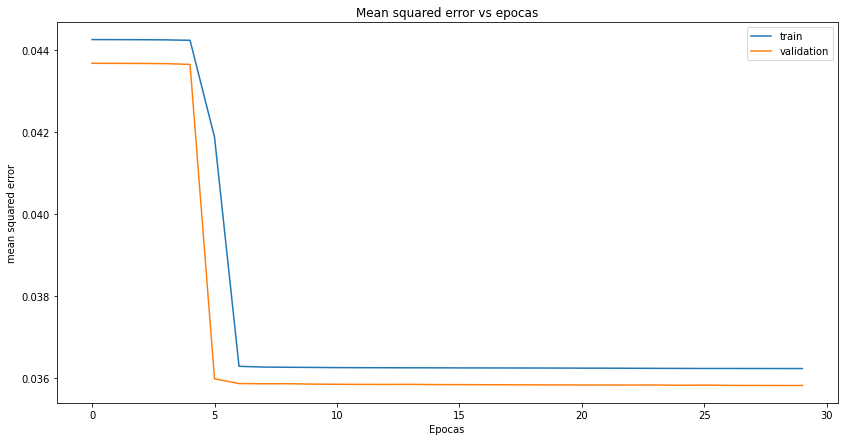

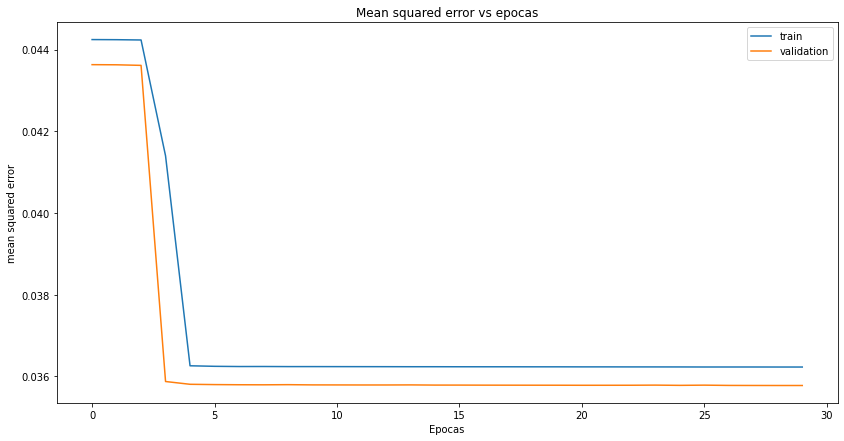

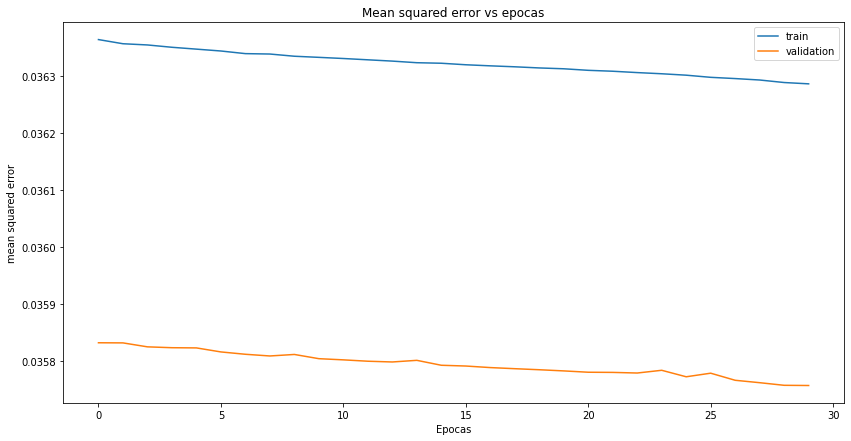

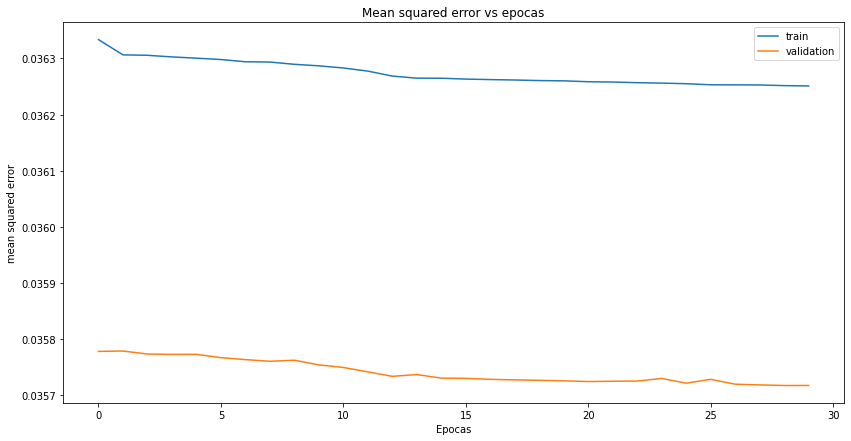

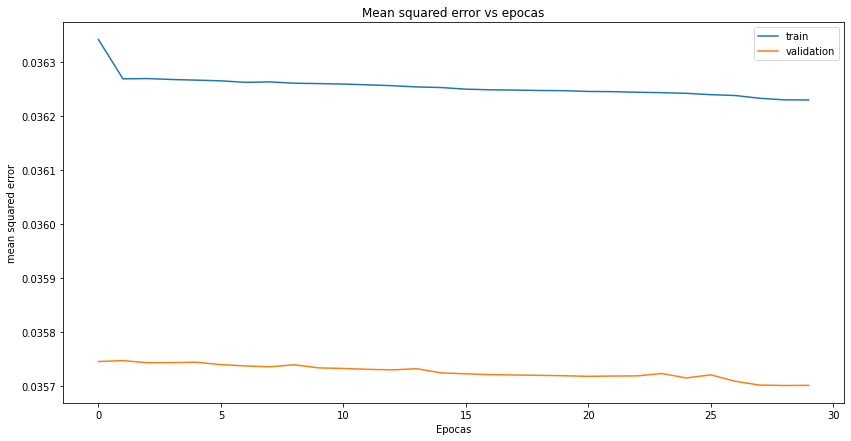

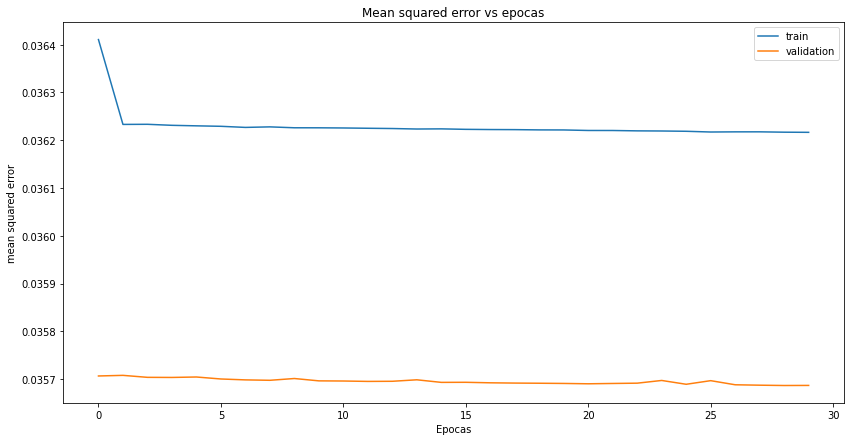

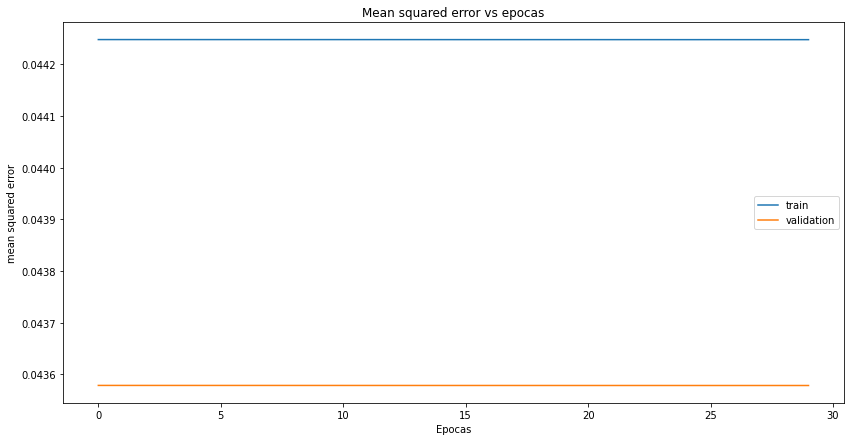

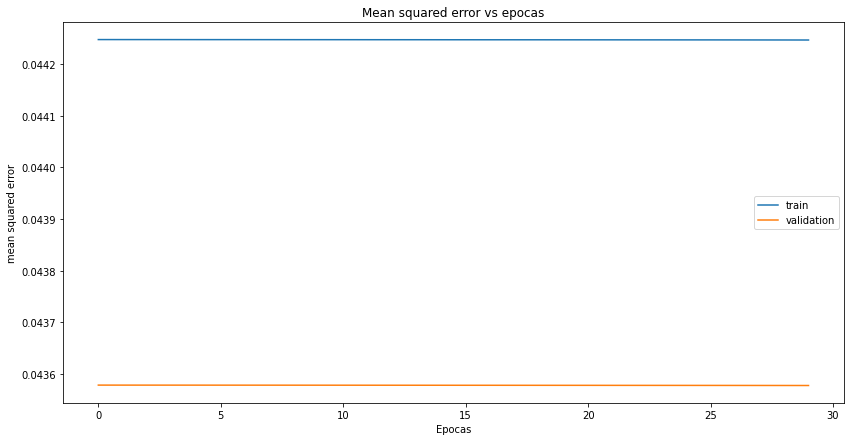

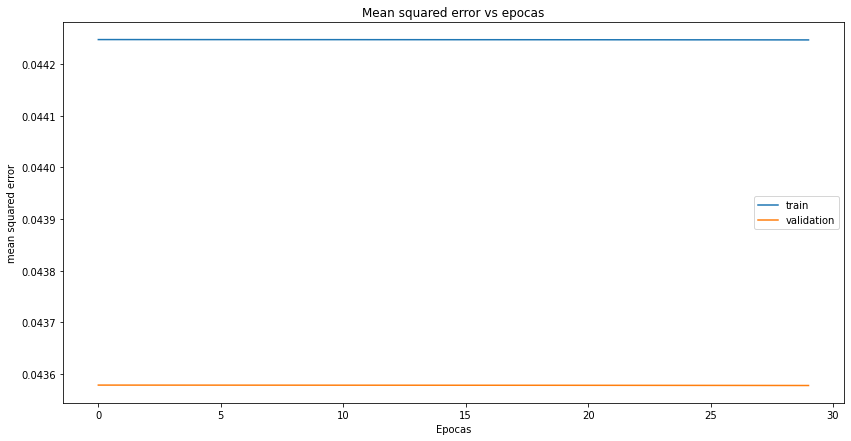

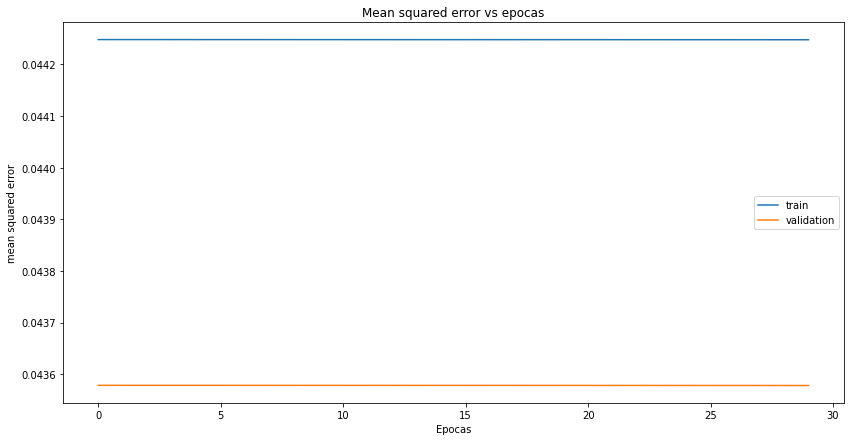

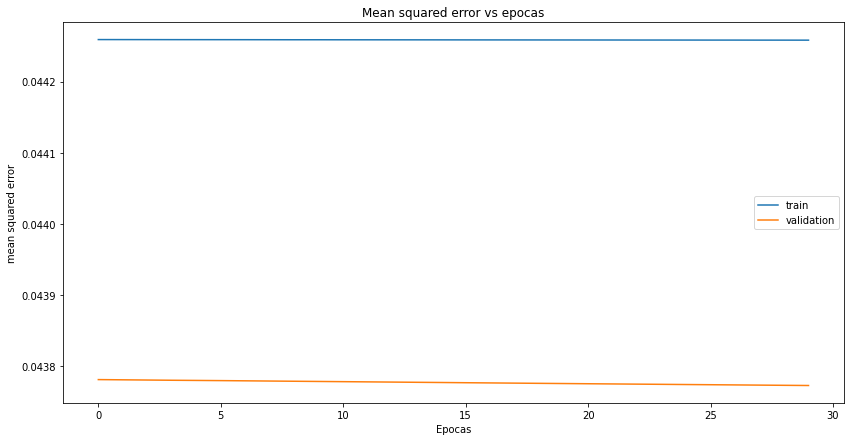

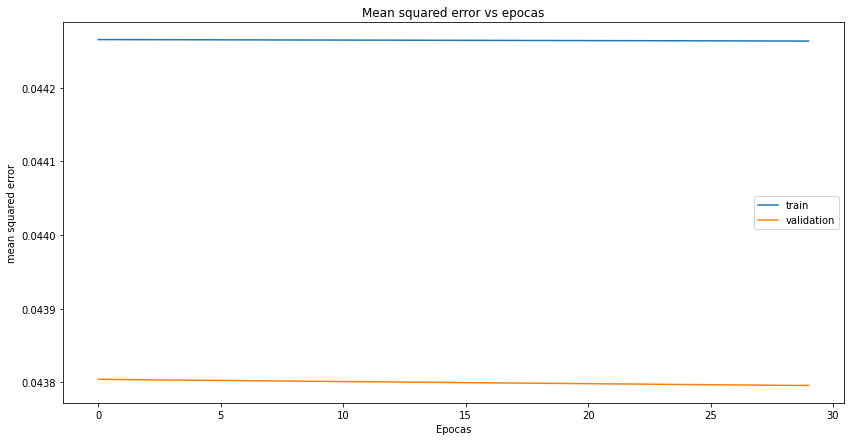

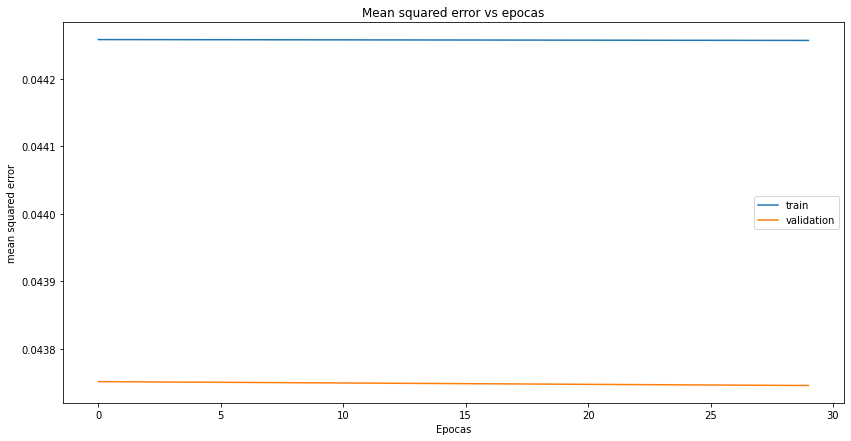

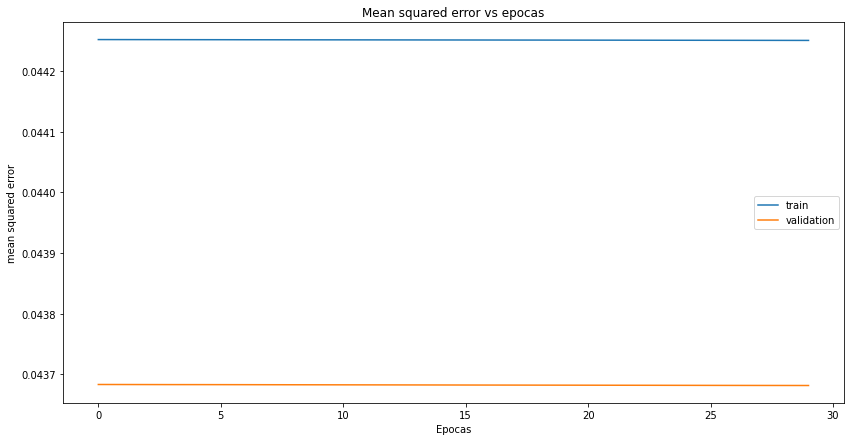

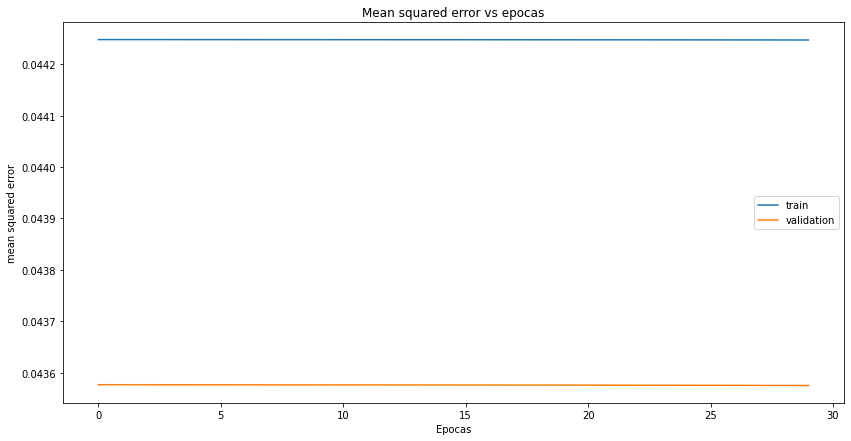

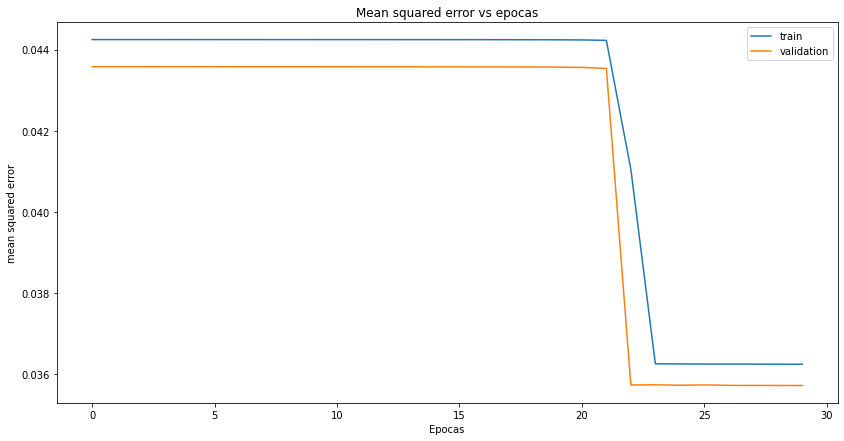

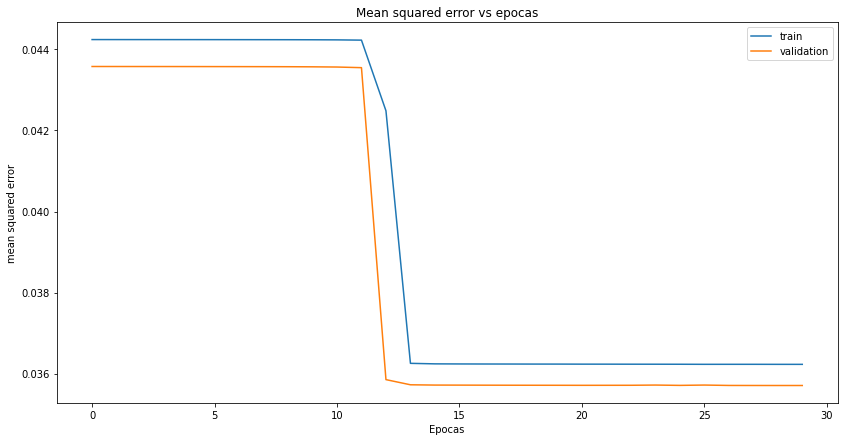

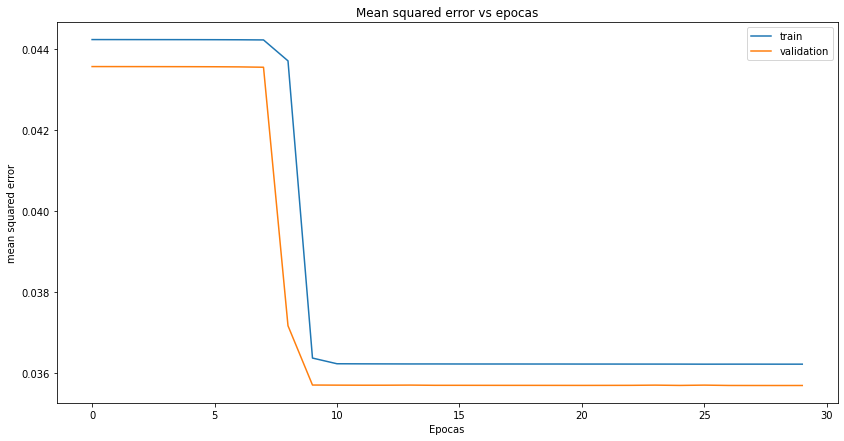

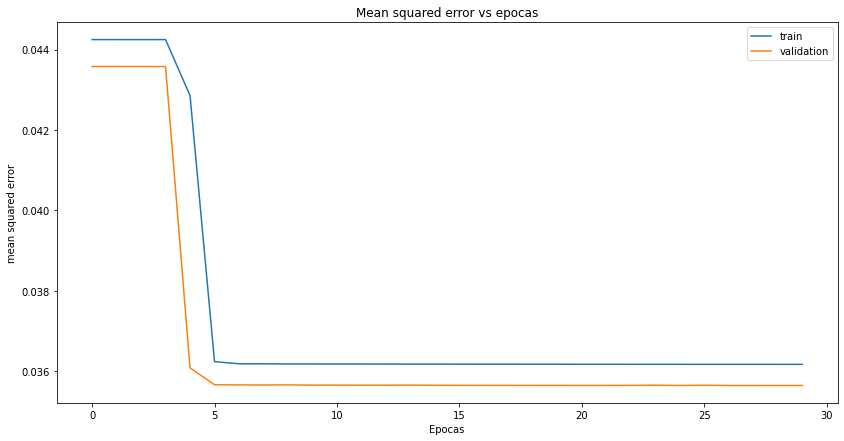

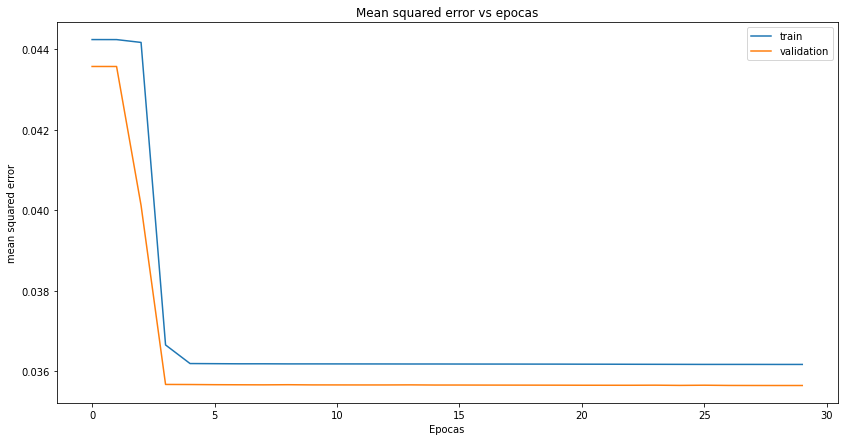

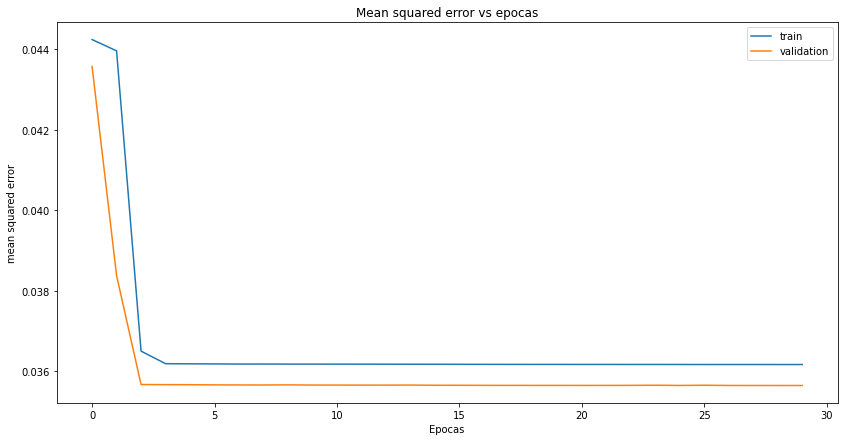

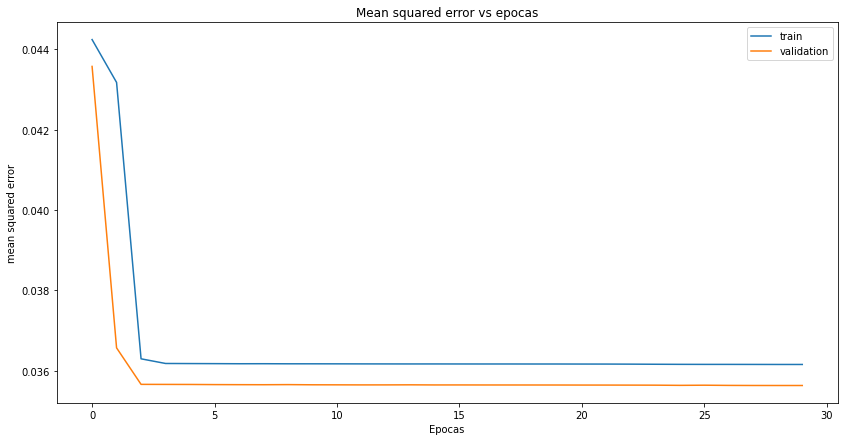

In [344]:
history_for_2 = {}
for nr in [4,16,32,64]:
  for ll in [1,2,4]:
    for id in [30,60,100,200]:
      reset_random_seeds()
      history_for_2[(nr,ll,id)] = build_nn_for(1, NEURONS=nr, LAYERS=ll, INPUT_DIM=id, EPOCHS=30, verbose=0)

In [348]:
trainlosses, vallosses = zip(*list(history_for_2.values()))
print('MIN TRAINING LOSS WAS', min(trainlosses))
print('MIN VAL LOSS WAS', min(vallosses))

MIN TRAINING LOSS WAS 0.03615812212228775
MIN VAL LOSS WAS 0.035634513944387436


#<b>TASK:</b> mejorar parametros para el fit de la dimension 1

.no hay mas nada por hacer, conformarse con esto o migrar

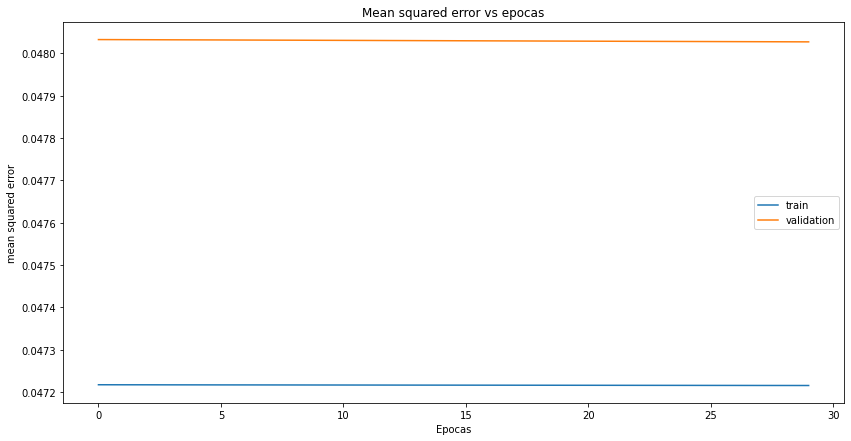

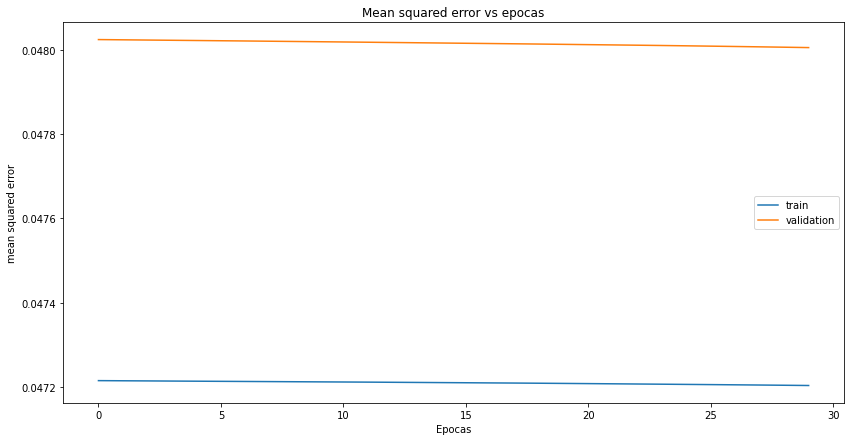

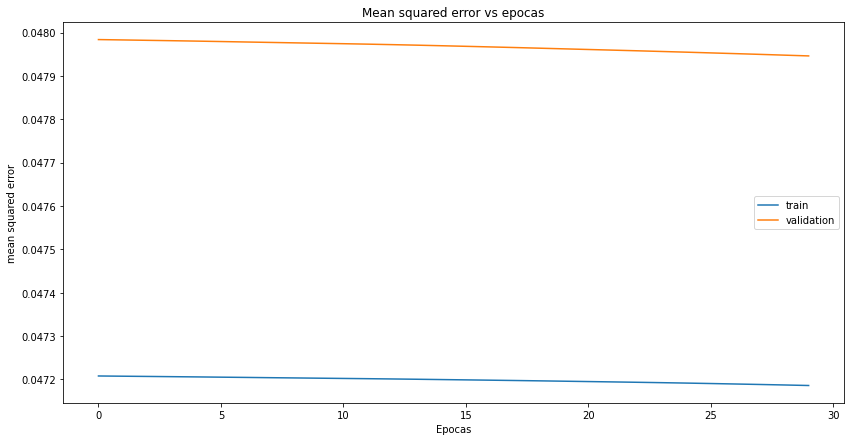

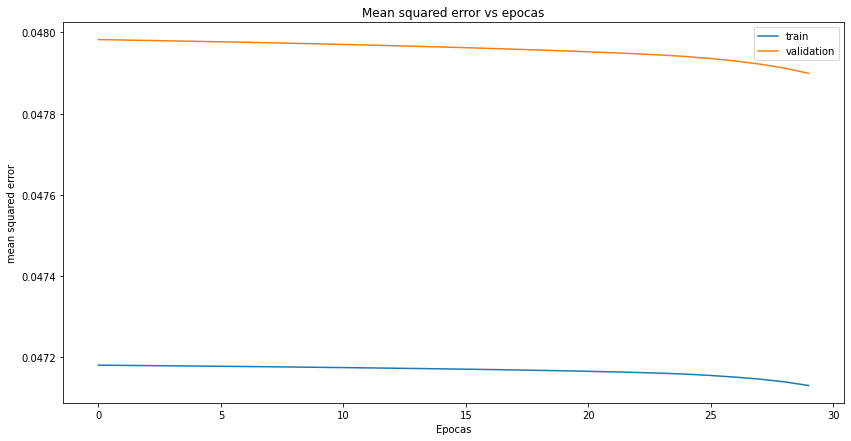

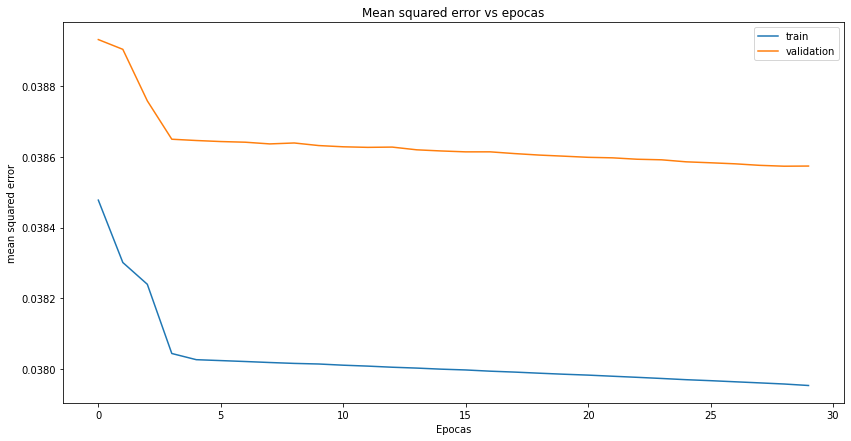

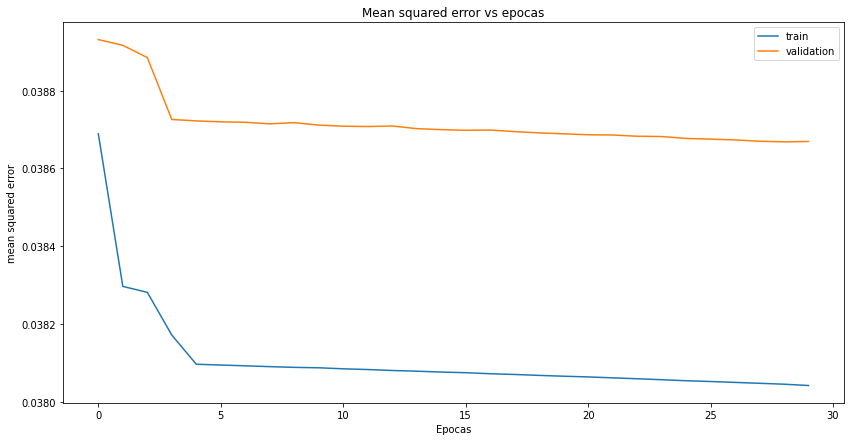

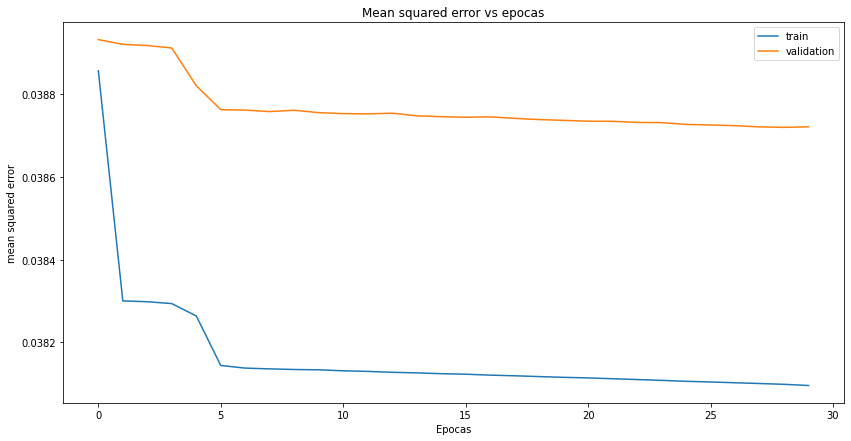

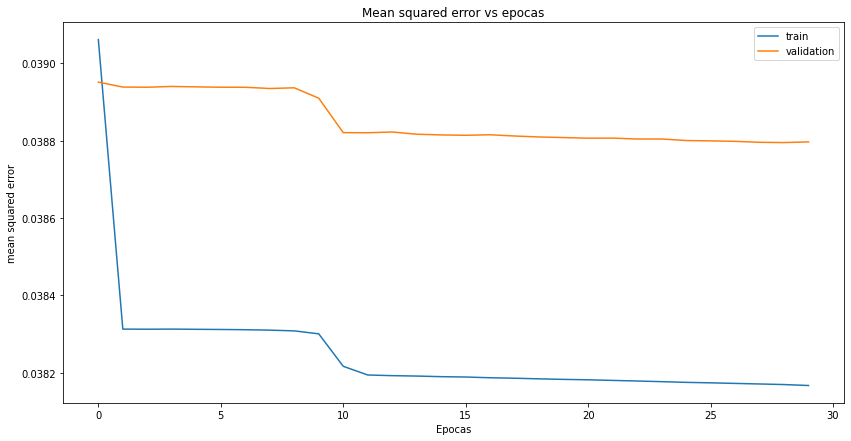

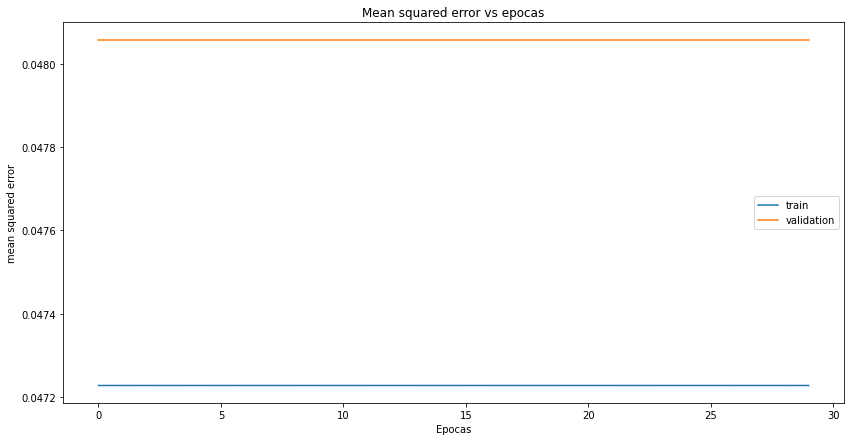

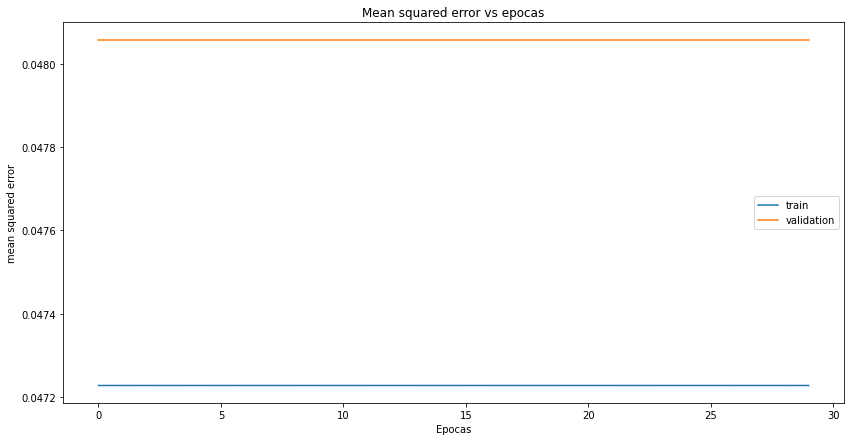

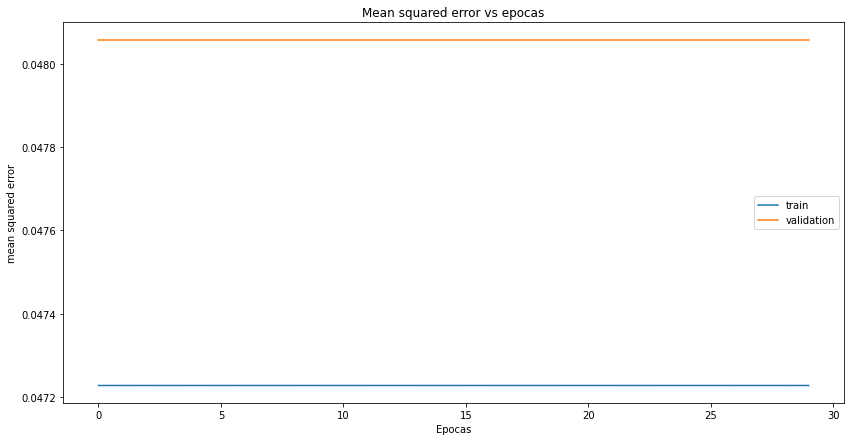

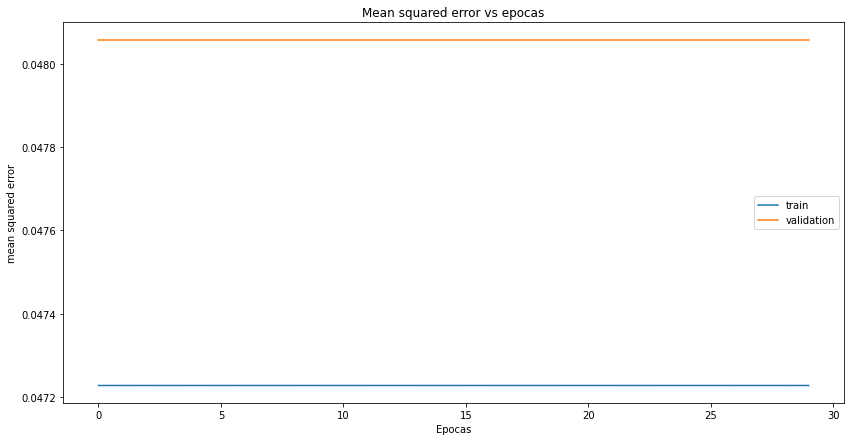

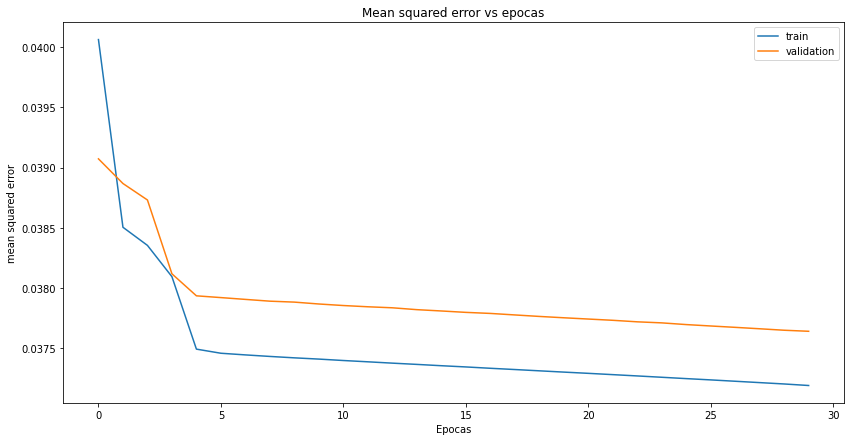

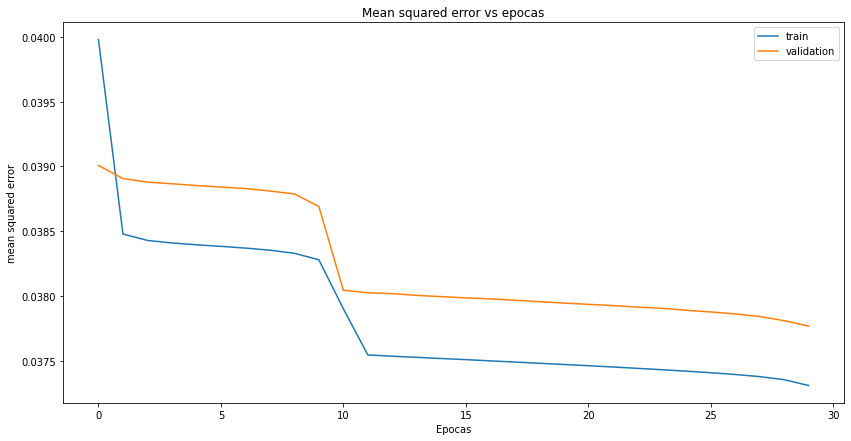

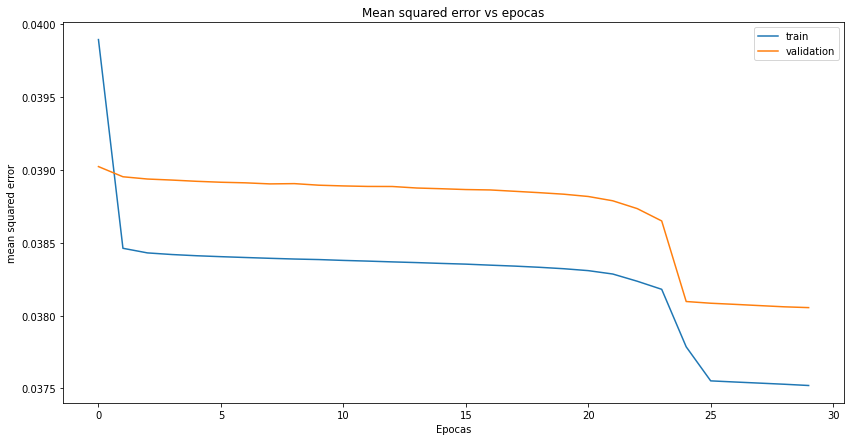

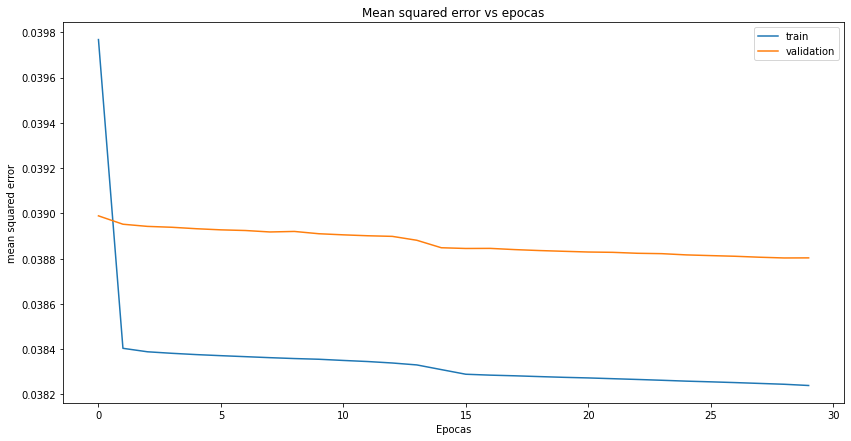

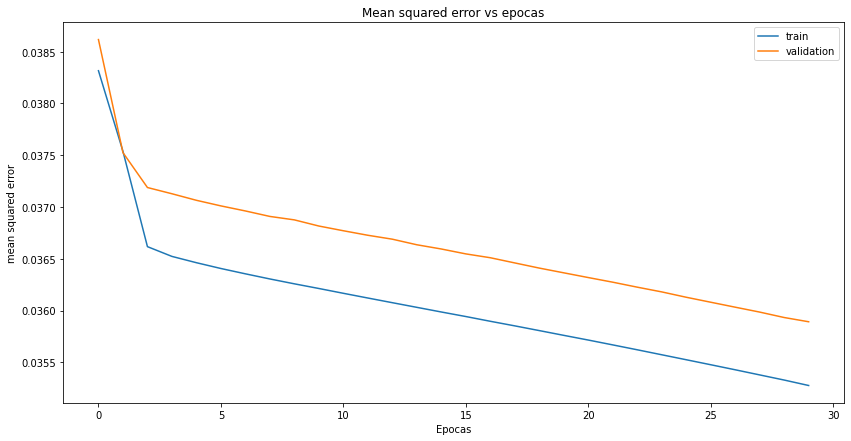

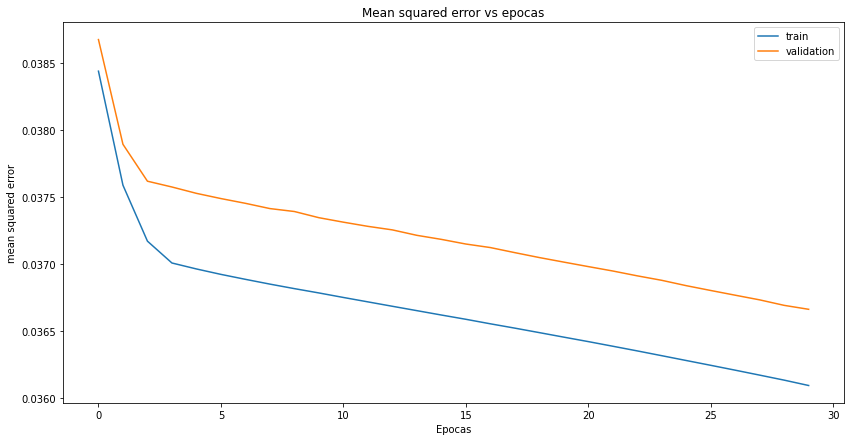

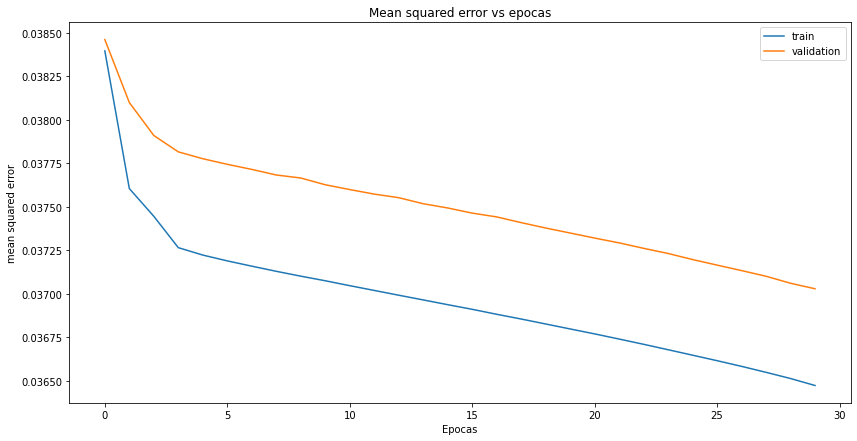

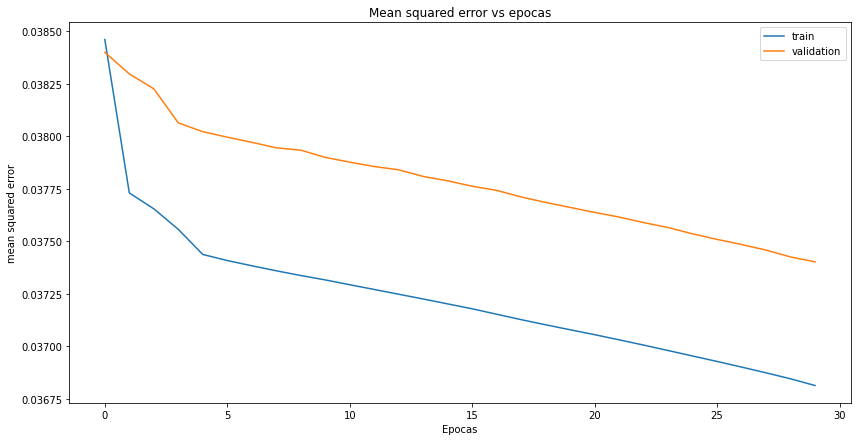

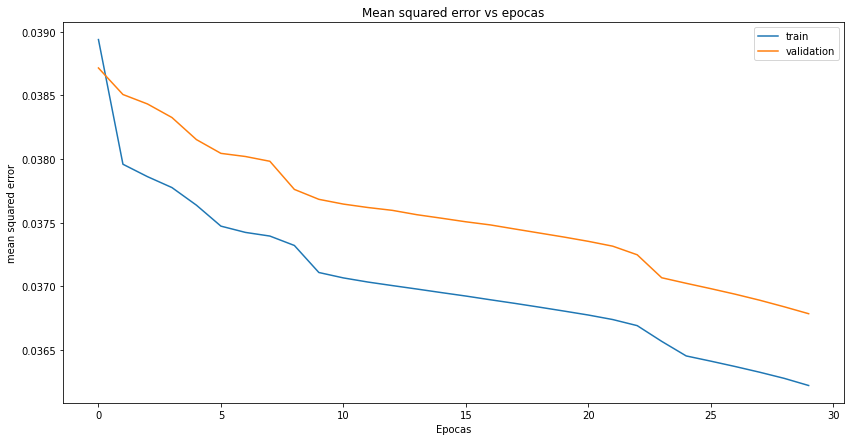

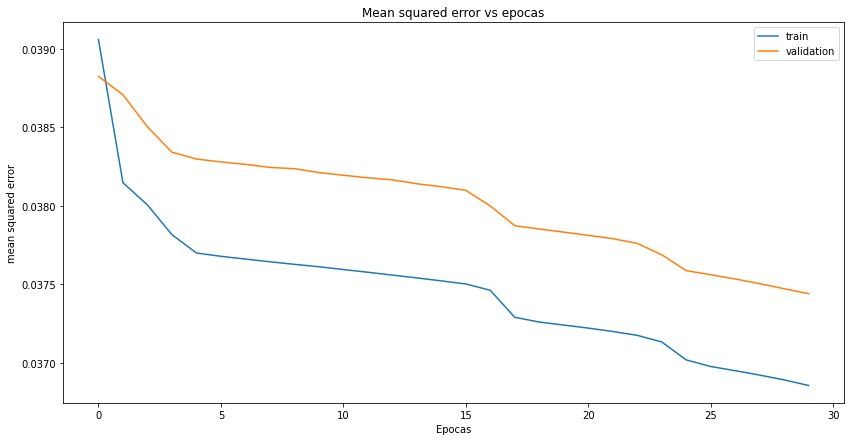

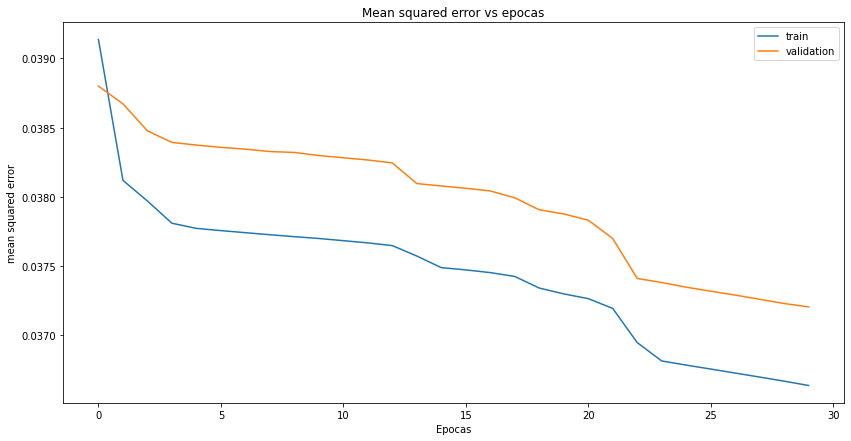

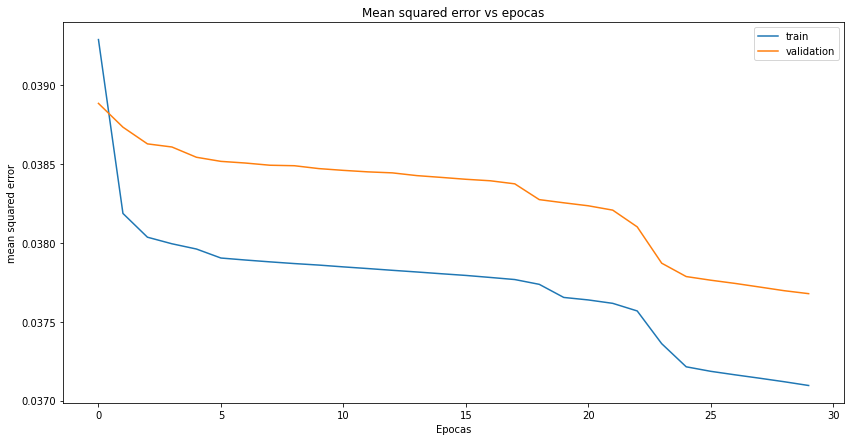

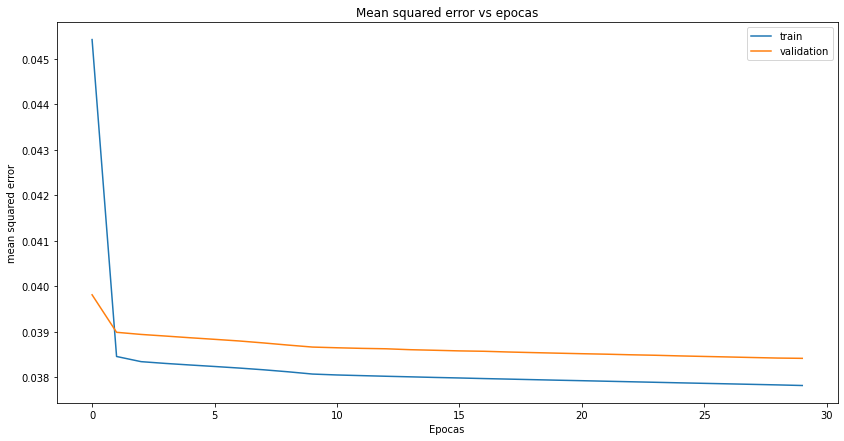

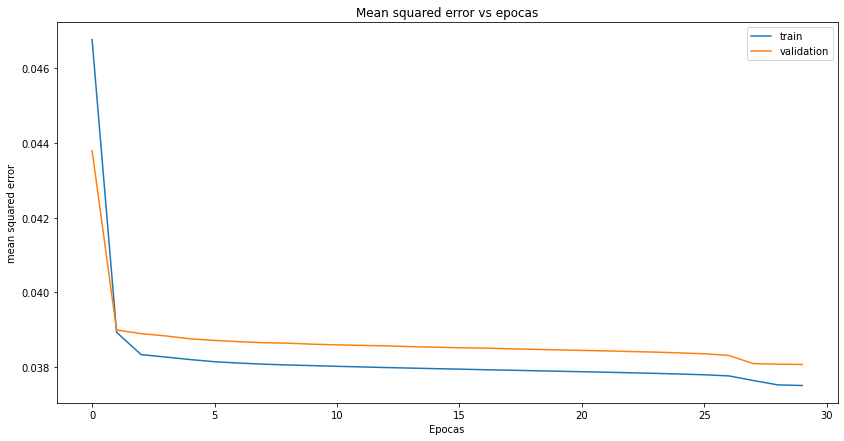

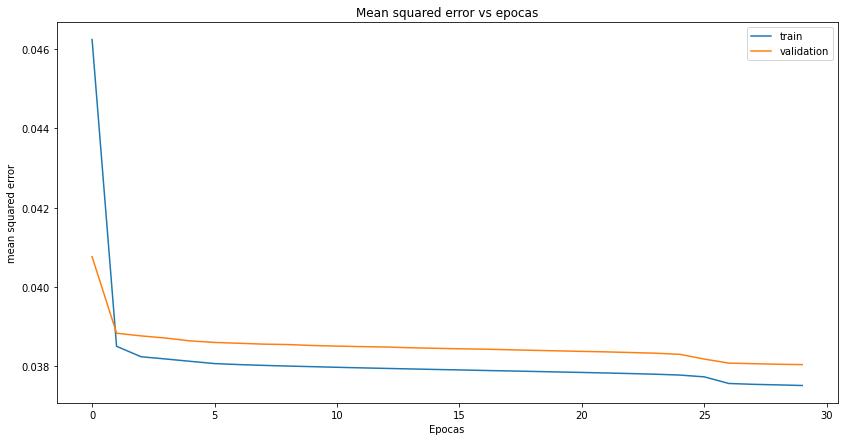

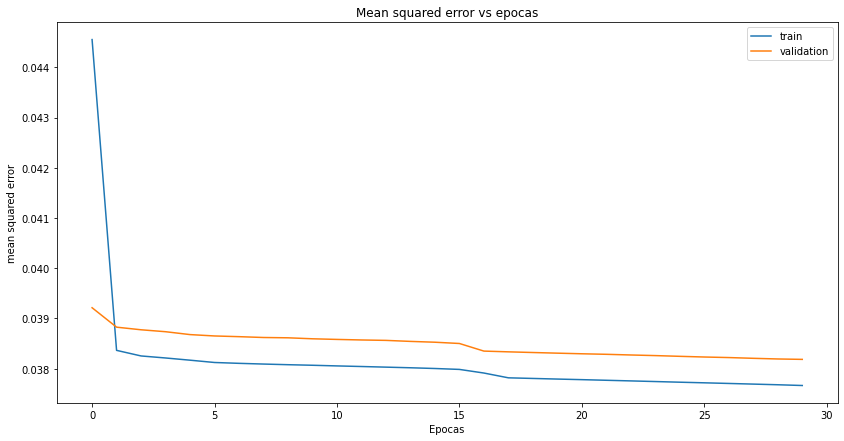

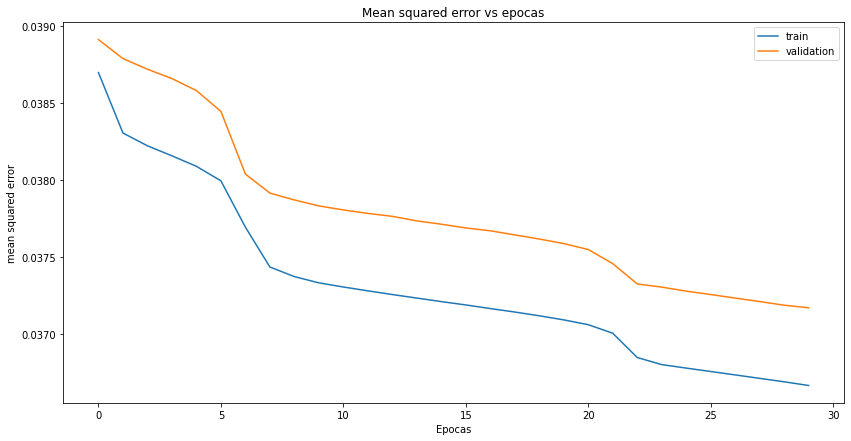

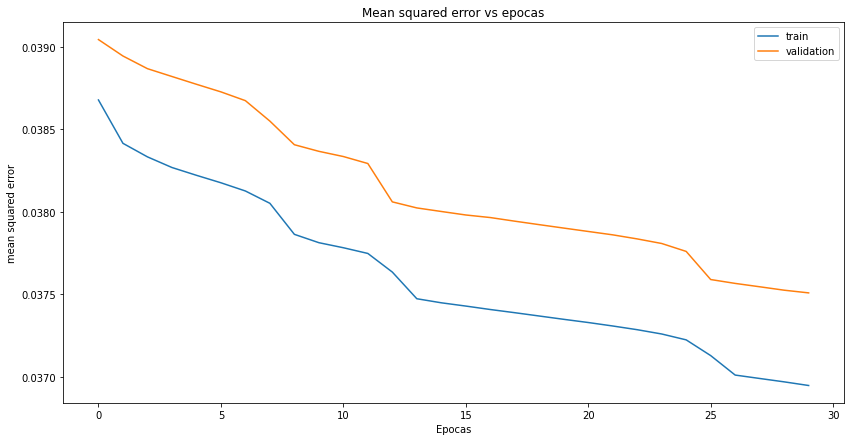

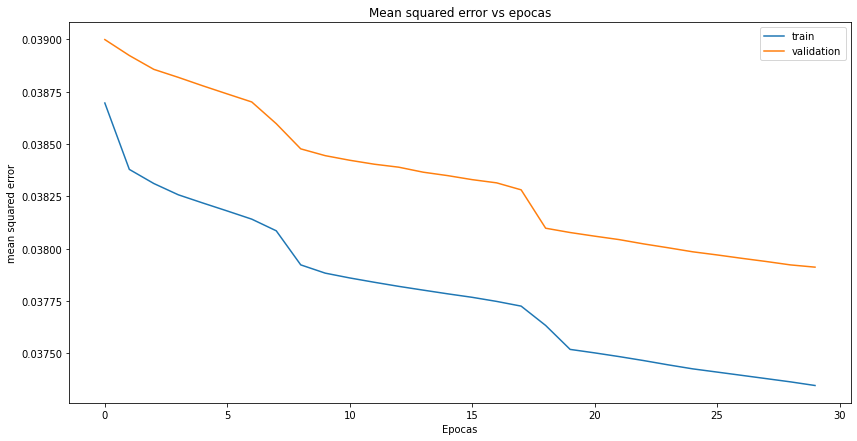

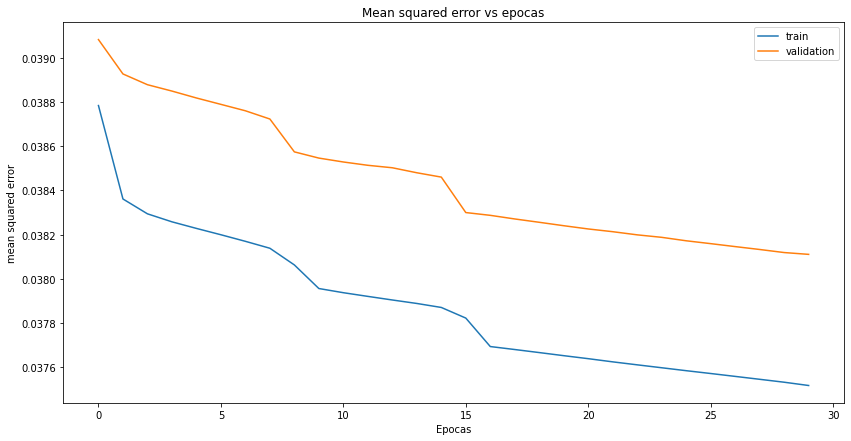

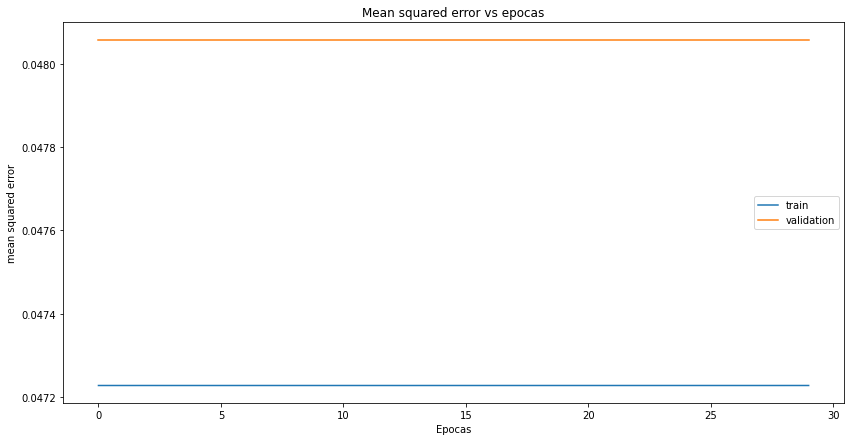

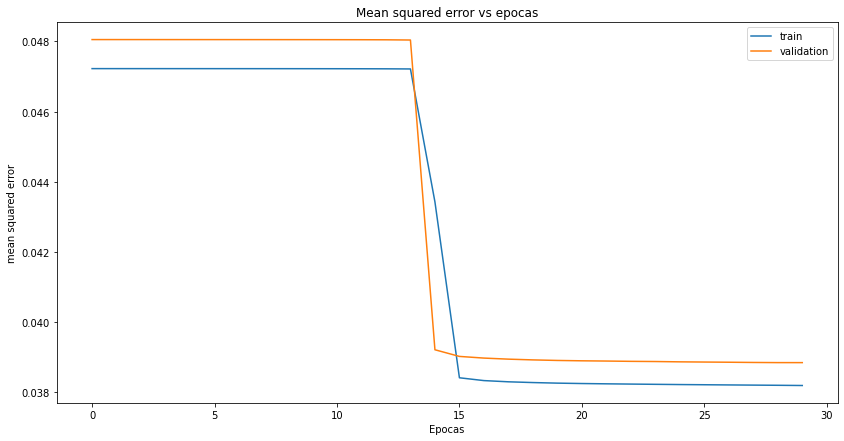

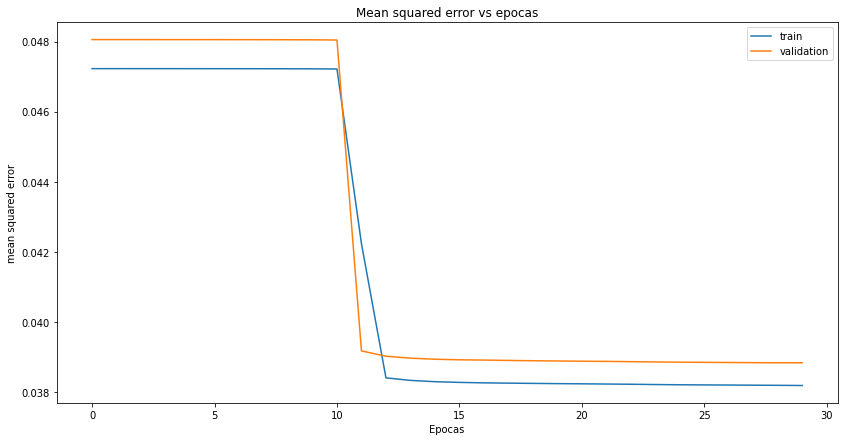

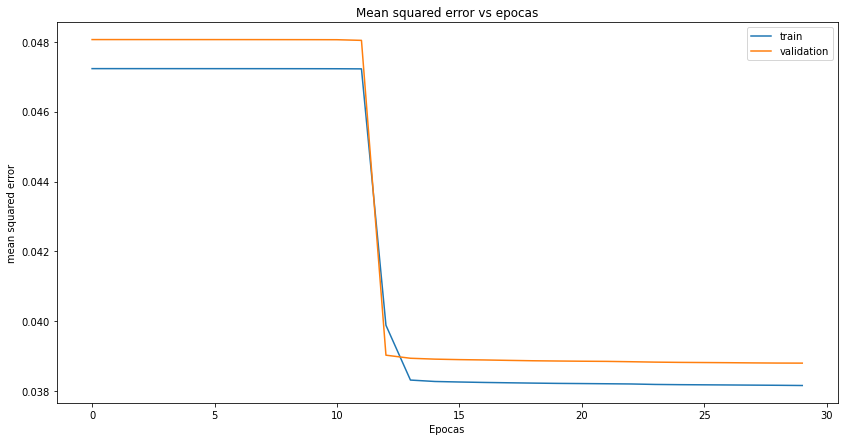

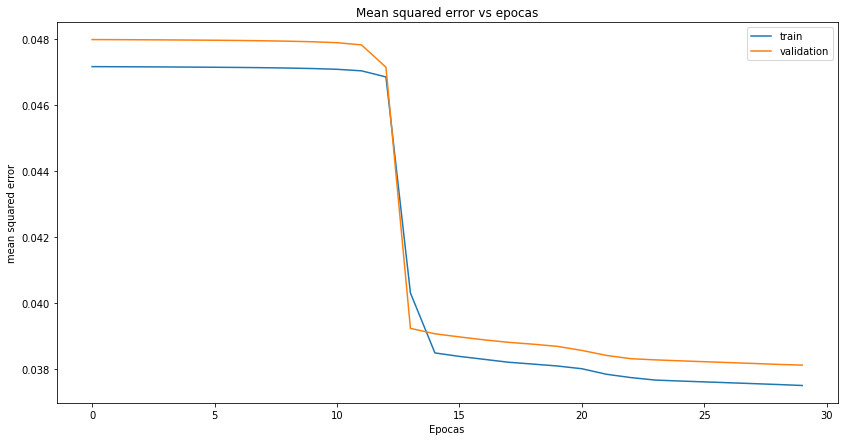

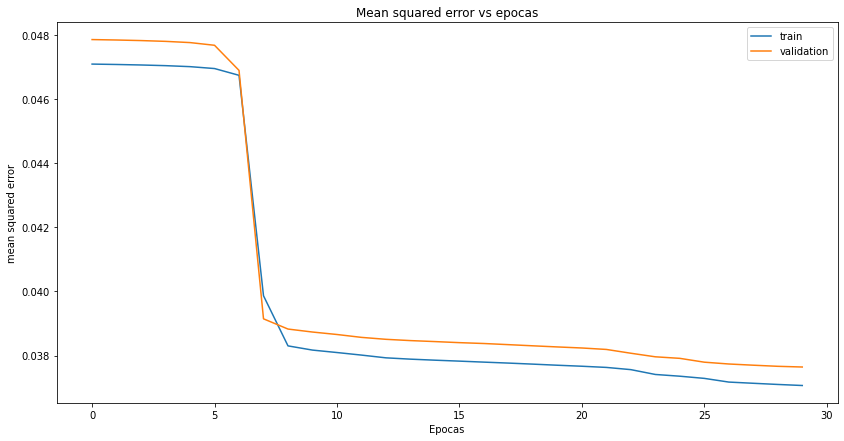

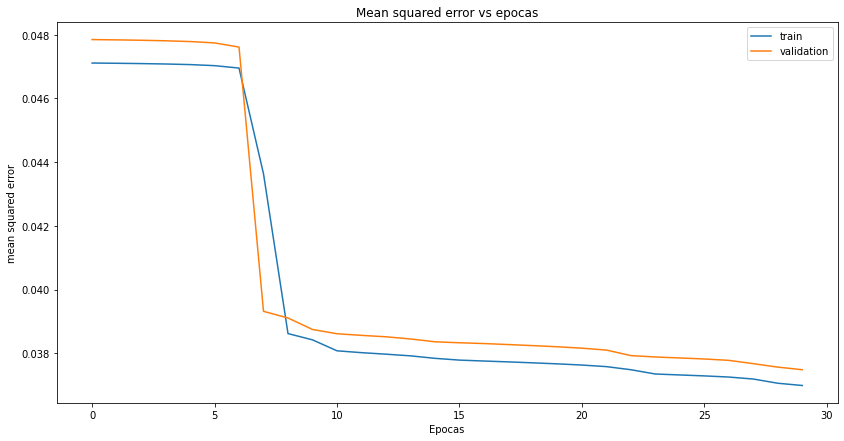

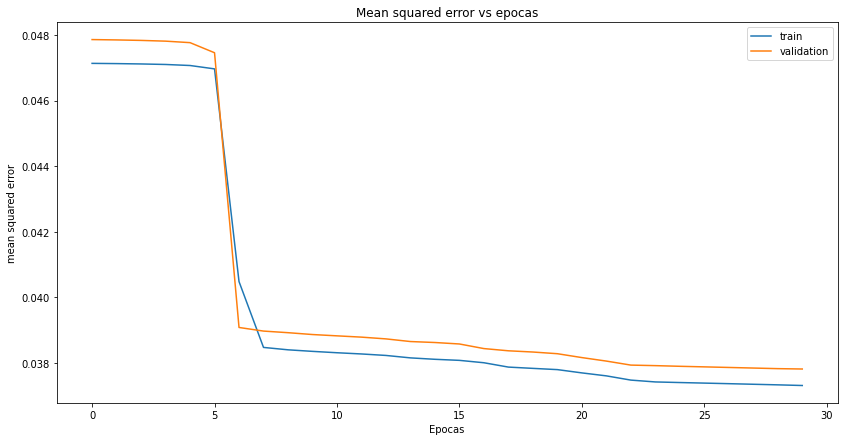

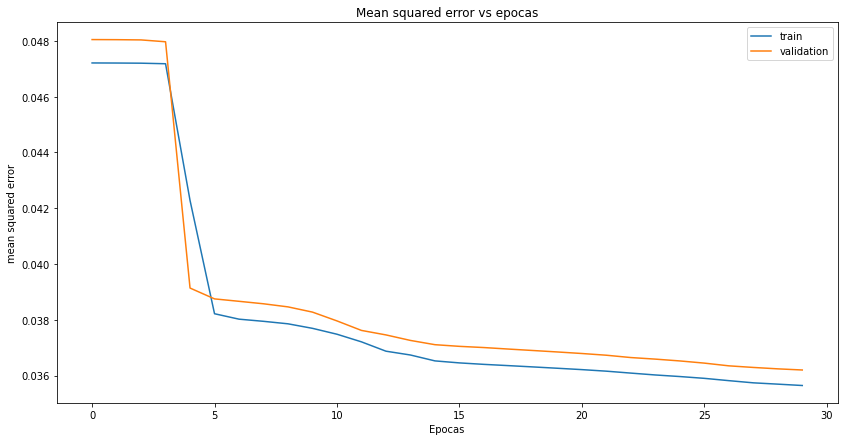

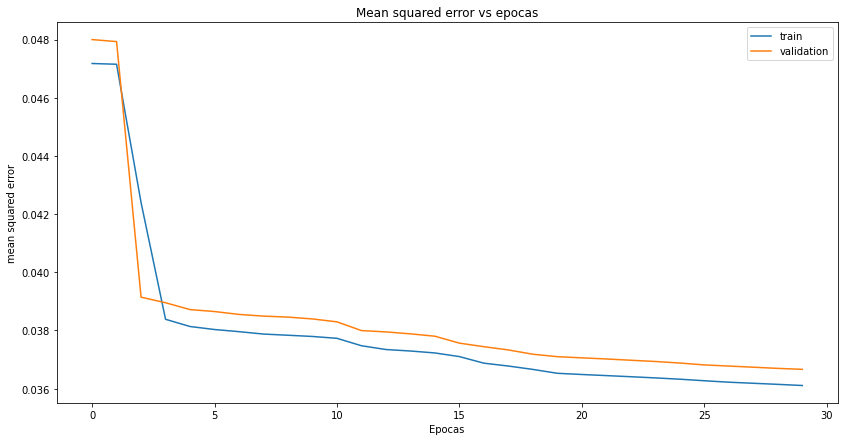

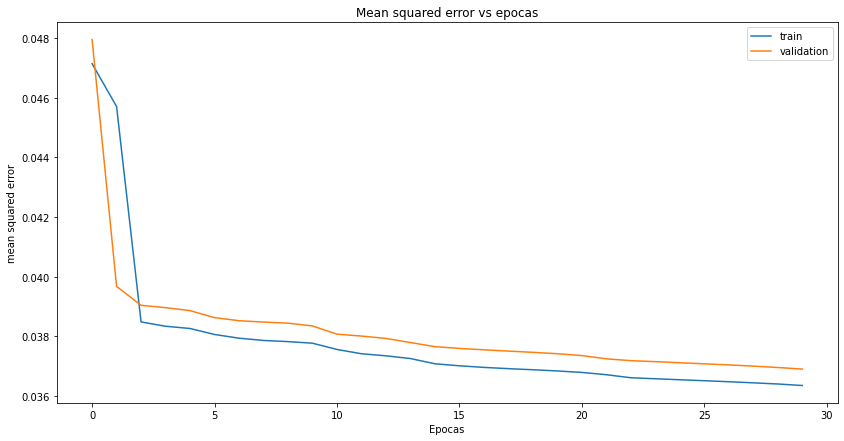

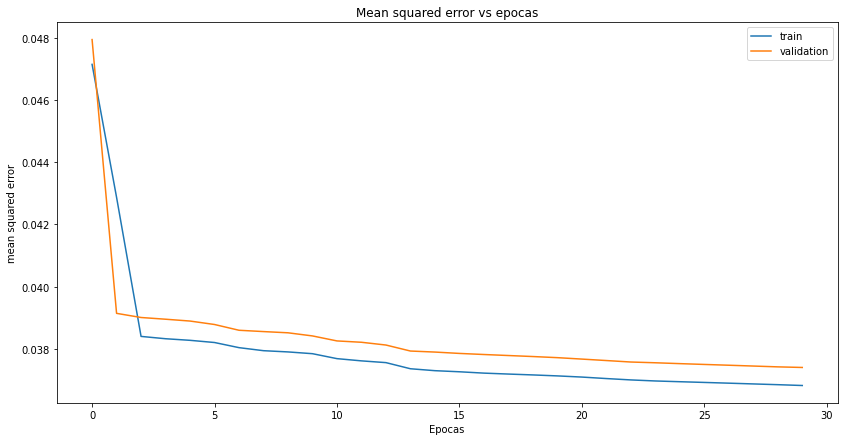

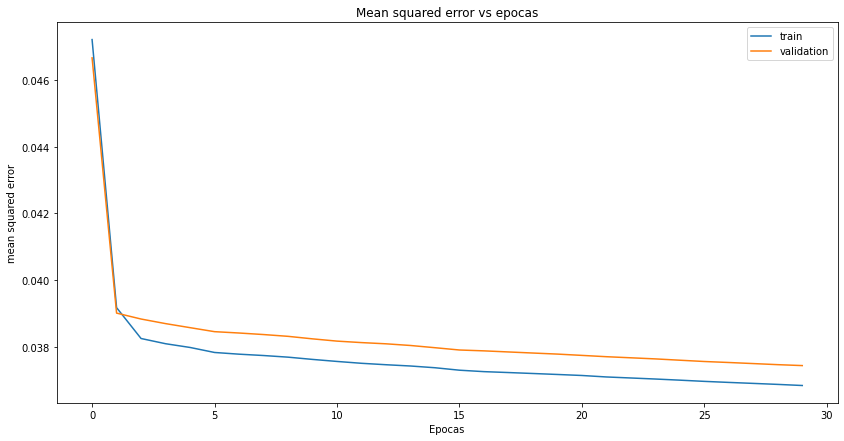

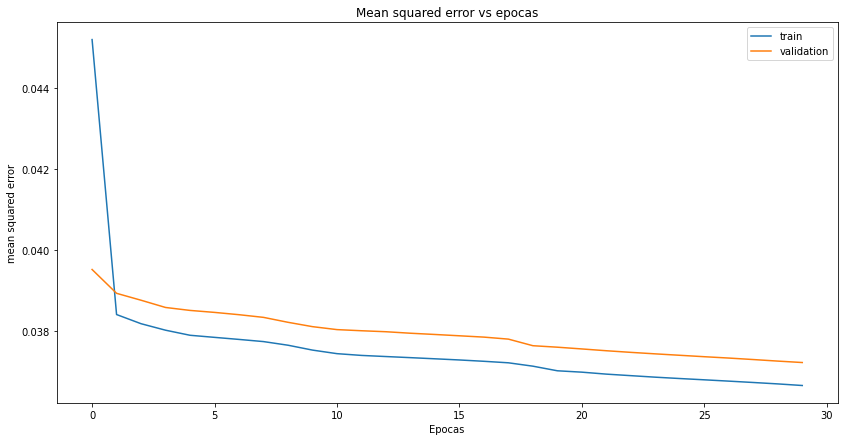

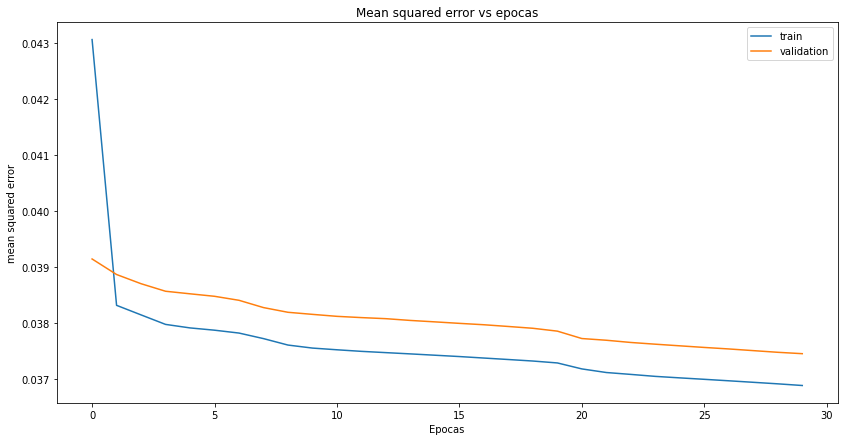

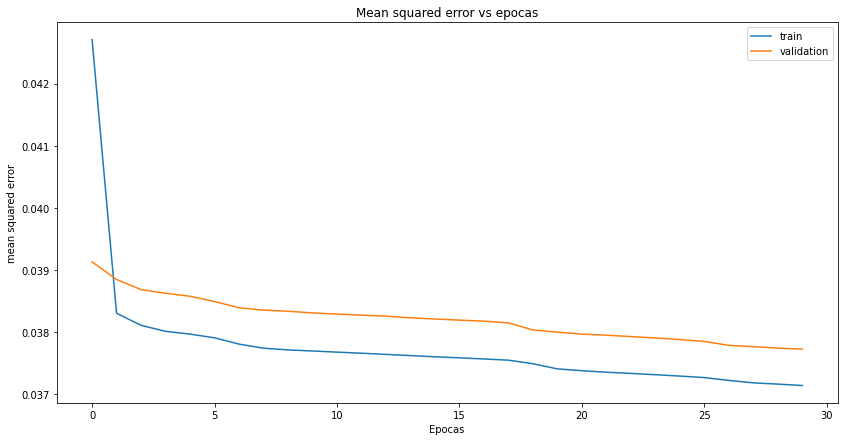

In [343]:
history_for_1 = {}
for nr in [4,16,32,64]:
  for ll in [1,2,4]:
    for id in [30,60,100,200]:
      reset_random_seeds()
      history_for_1[(nr,ll,id)] = build_nn_for(0, NEURONS=nr, LAYERS=ll, INPUT_DIM=id, EPOCHS=30, verbose=0)


In [347]:
trainlosses, vallosses = zip(*list(history_for_1.values()))
print('MIN TRAINING LOSS WAS', min(trainlosses))
print('MIN VAL LOSS WAS', min(vallosses))

MIN TRAINING LOSS WAS 0.03527646139264107
MIN VAL LOSS WAS 0.035891879349946976


#<b>TASK:</b> A recurrent architecture (e.g. LSTM for regression)

In [ ]:
# Your code goes here

#<b>TASK:</b> A 1-D convolutional network

(falta batchear los datos en time-windows y correr el fit)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mean_squared_error', optimizer='SGD',)# metrics=['accuracy'])
	# fit network
	history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	#_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return history.history

In [10]:
(X_train_scaled, y_train_scaled,
          X_val_scaled, y_val_scaled,
          X_test_scaled, y_test_scaled) = make_data(0,False)

In [36]:
def window_transformer(x,y, tau):
  containerx, containery = [],[]
  for j in range(len(x[:,0])):
    local_containerx = []
    for i in range(len(x[0,:])-tau):
      local_containerx.append(x[j,i:i+tau])
    containery.append([y[j,:]]*tau)
    containerx.append(local_containerx)
  return np.asarray(containerx), np.asarray(containery)

In [ ]:
result = window_transformer(X_test_scaled, y_test_scaled, 100)

#<b>old stuff:</b> 
(dont waste your time here plz)

Q: Que tal predice un polinomio de grado M???

<i>Spoiler alert: taylor de dimension alta es numerically infeasible</i>
<i>Intuicion: El mismo argumento de dimensionalidad vale para hacer infeasible memory-based methods, e.g. cluster regression y SVM</i>

In [125]:
degree = [1,2,3,4]
alpha = np.logspace(-3,1.5,4)
history = {x:{} for x in range(7)}
history_train = {x:{} for x in range(7)}
for deg in degree:
  datas = make_data(deg)
  for a in alpha:
    model = make_model(a)
    for i in range(7):
      history_train[i][(deg, a)] = []
      history[i][(deg, a)] = []
      fit_model(model, *datas, history[i][(deg, a)], history_train[i][(deg, a)], i)

<i>for a specific set of parameters you can watch the optimization process in loss vs iterations for each of the 7 parameters we are fitting</i>

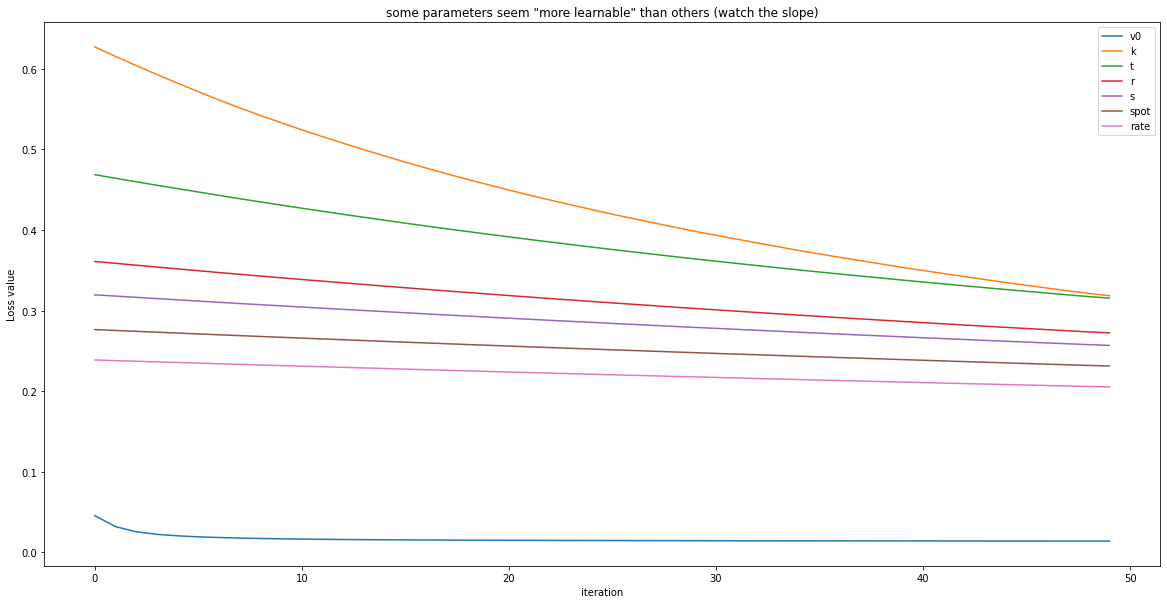

In [61]:
column_names = ['v0', 'k', 't', 'r', 's', 'spot', 'rate']
f,ax = plt.subplots(figsize=(20,10))
for i in range(7):
  ax.plot(history[i][(1, 1e-3)], label=column_names[i])

ax.set_xlabel('iteration');ax.set_ylabel('Loss value')
plt.title('some parameters seem "more learnable" than others (watch the slope)')
ax.legend();plt.show()

<i>cost functions</i>

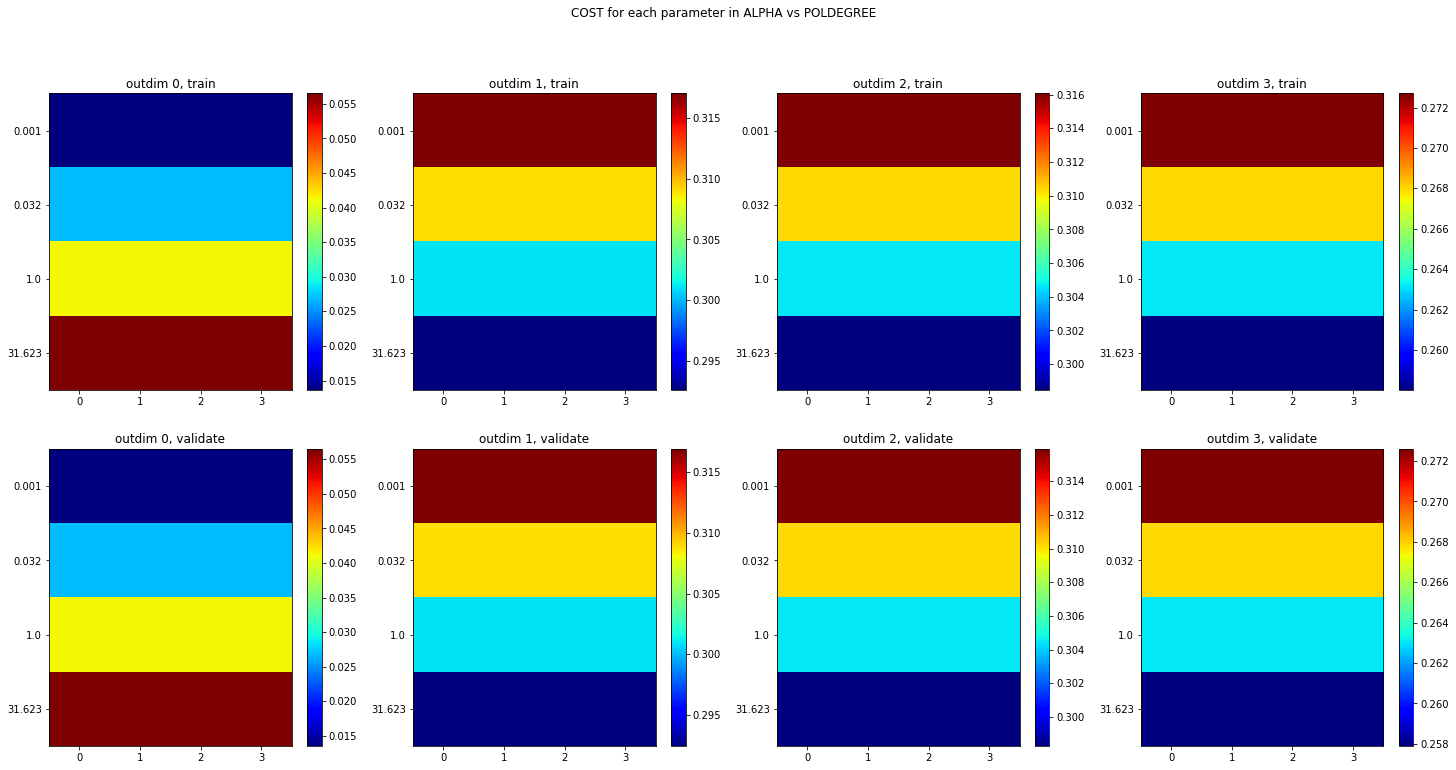

In [194]:
f, ax = plt.subplots(2,4, figsize=(25,12))
for IX in range(4):
  # for training data
  view_paramgrid(history_train,f, ax[0,IX], IX, 'jet')
  ax[0,IX].set_title(f'outdim {IX}, train')
  ax[1,IX].set_title(f'outdim {IX}, validate')
  # for validation data
  view_paramgrid(history,f, ax[1,IX], IX, 'jet')
f.suptitle('COST for each parameter in ALPHA vs POLDEGREE')
plt.show()